## Train iForest on CT reads from cc1 and reads from illumina ground truth sites of wt and ko murine datasets (no mismatches and indels)

Here a training of an iForest models on CT reads extracted from cc1 sample and from CT reads mapping on illumina ground truth sites of wt and ko samples from the murine data. We can control approximately in this way the contamination parameter of the iforest algorithm.

In [1]:
# import basic modules
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
# add to path folder with CtoUclassifier package
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min import utils


### --- utils functions --- ################
def retrieve_depth_stranded(bam_file, region, pos1based, strand):
    pos0based=pos1based-1
    for pileupcolumn in bam_file.pileup(region, pos0based, pos0based+1, truncate=True, max_depth=1000000, min_base_quality=0):
        column = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
        if strand == "+":
            depth_stranded = sum(1 for b in column if b.isupper())
        elif strand == "-":
            depth_stranded = sum(1 for b in column if b.islower())
    return depth_stranded

############################################

In [2]:
# define datasets paths
wt_filepaths = glob.glob("/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.basecalling_features/wt.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*.tsv")
ko_filepaths = glob.glob("/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.basecalling_features/ko.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*.tsv")
cc1_filepaths = glob.glob("/lustre/bio_running/C_to_U_editing_minimap2_spliced/cc1.basecalling_features/cc1.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*")

# load into datasets
col_names = ["region", "position", "read_name", "strand"]+[f"pos{i}" for i in range(-3,4)]+["ins"]
dfCT_wt = pd.concat([pd.read_table(d, header=None, names=col_names) for d in wt_filepaths], axis = 0)
dfCT_ko = pd.concat([pd.read_table(d, header=None, names=col_names) for d in ko_filepaths], axis = 0)
dfCT_cc1 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in cc1_filepaths], axis = 0)

In [3]:
# see wt
dfCT_wt

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,3286403,f3b597d8-2821-4d25-8c35-dc65bcf46e0a,+,7.0,15.0,11.0,4.0,18.0,21.0,30.0,0.0
1,chr5,3286403,244767df-eb4a-40fb-b1da-7cb3a6d792f5,+,6.0,11.0,11.0,9.0,16.0,-11.0,-6.0,0.0
2,chr5,3286407,e8c9bc21-bfb9-47cb-92df-a9ca2f12cc8c,+,6.0,4.0,6.0,7.0,18.0,13.0,-23.0,0.0
3,chr5,3286410,1d0cd8af-4469-447f-807a-05143e9c0325,+,4.0,5.0,6.0,6.0,11.0,9.0,17.0,0.0
4,chr5,3286410,7bf3c277-bb64-4be0-8e49-71a76857728a,+,7.0,4.0,6.0,5.0,13.0,10.0,27.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68451,chr13,120169593,87ea5e75-10e9-4a82-a428-1b070b4b3acc,+,15.0,-0.0,13.0,13.0,15.0,13.0,25.0,0.0
68452,chr13,120169593,4eac5795-fb82-4151-ba25-673385aafcbe,+,13.0,-0.0,18.0,6.0,6.0,9.0,27.0,0.0
68453,chr13,120169593,e0b38f22-c16a-4af7-a006-0f939379379d,+,18.0,-0.0,26.0,4.0,6.0,10.0,19.0,0.0
68454,chr13,120169593,68621b59-d975-492c-8334-dcc133b05434,+,16.0,-0.0,17.0,4.0,13.0,3.0,27.0,0.0


In [4]:
# see ko
dfCT_ko

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,3286403,0a7afbd1-b00b-4bec-b9e0-f832474c6b74,+,8.0,6.0,6.0,10.0,11.0,-8.0,6.0,0.0
1,chr5,3286406,e9b7aab2-f8b0-41ee-94de-73919661c5e8,+,13.0,-0.0,-0.0,3.0,7.0,8.0,4.0,0.0
2,chr5,3286410,d910bcea-9e54-4420-8f1e-c0d9dbc0d07e,+,18.0,19.0,24.0,20.0,12.0,9.0,19.0,0.0
3,chr5,3286410,c481b263-2d72-45b6-be1b-c9991478fcab,+,7.0,4.0,4.0,17.0,21.0,19.0,25.0,2.0
4,chr5,3286410,a0121be8-92bc-4387-a230-db3823613159,+,12.0,12.0,14.0,6.0,-3.0,18.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
90610,chr13,120169547,2bbf0fbd-2715-4dcf-baa3-950b16ff97ca,+,11.0,15.0,-0.0,5.0,20.0,23.0,21.0,0.0
90611,chr13,120169567,20f16875-1a38-4772-b188-01ddd49a3b05,+,3.0,-0.0,-0.0,6.0,-4.0,5.0,3.0,0.0
90612,chr13,120169593,b478cc97-881b-4272-aee7-8f0a262d3d2c,+,12.0,-0.0,11.0,4.0,10.0,4.0,22.0,0.0
90613,chr13,120169593,31747366-f3b2-49a4-a668-5773e0480ba8,+,9.0,-0.0,12.0,6.0,12.0,10.0,29.0,0.0


In [5]:
# see curlcake 1
dfCT_cc1

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr1,37,06587ab2-0a88-484e-9764-56b7986cd63c,+,6.0,-6.0,5.0,4.0,11.0,4.0,15.0,0.0
1,chr1,37,2751a494-6eb8-4a1a-970c-d7dfa429b093,+,6.0,9.0,6.0,4.0,21.0,20.0,22.0,0.0
2,chr1,47,06155312-a4a5-4f99-9d8e-03db60ca6b59,+,33.0,17.0,14.0,9.0,22.0,28.0,30.0,1.0
3,chr1,47,32894544-05ba-484c-8648-6288e8d4da2c,+,12.0,3.0,-4.0,5.0,22.0,21.0,-12.0,0.0
4,chr1,47,14e46880-b504-406c-ba0a-de90e10e6804,+,11.0,11.0,7.0,10.0,5.0,5.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68136,chr2,2484,efeb7f47-9c5e-4956-85e9-b3b0b4acf18a,+,7.0,18.0,8.0,4.0,19.0,22.0,20.0,0.0
68137,chr2,2484,b9e918bf-6122-4fe6-9d37-6300d74b6a9f,+,13.0,19.0,-4.0,4.0,23.0,26.0,29.0,0.0
68138,chr2,2484,c3602455-a606-47ba-b4e8-262f5ba058c2,+,8.0,9.0,8.0,16.0,19.0,25.0,22.0,0.0
68139,chr2,2484,ae5805d3-7d4f-44e1-af45-7724f7d87114,+,2.0,4.0,8.0,4.0,20.0,21.0,17.0,0.0


In [6]:
# focus only on reads of illumina ground truth sites for wt and ko runs
col_names = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39_columns.txt", header=None).T.values[0].tolist()
illumina_gt = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39.tsv", header=None, names=col_names)
illumina_gt

,contig_mm39,pos_mm39,contig_mm10,pos_mm10,ref_base,strand,cov_WT,MeanQual_WT,"BaseCount_WT[A,C,G,T]",Subs_WT,SubsFreq_WT,cov_KO,MeanQual_KO,"BaseCount_KO[A,C,G,T]",Subs_KO,SubsFreq_KO,PositionAnnotation,gene_name
0,chr1,4915683,chr1,4845460,C,1,290,35.40,"[0, 258, 0, 32]",CT,0.11,184,35.08,"[0, 184, 0, 0]",-,0.0,UTR3,Lypla1
1,chr1,4915694,chr1,4845471,C,1,290,35.45,"[0, 258, 0, 32]",CT,0.11,183,35.54,"[0, 183, 0, 0]",-,0.0,UTR3,Lypla1
2,chr1,4915851,chr1,4845628,C,1,142,35.19,"[0, 135, 0, 7]",CT,0.05,83,35.00,"[0, 83, 0, 0]",-,0.0,UTR3,Lypla1
3,chr1,4916384,chr1,4846161,C,1,183,35.79,"[0, 164, 0, 19]",CT,0.10,134,35.85,"[0, 134, 0, 0]",-,0.0,UTR3,Lypla1
4,chr1,4967044,chr1,4896821,C,1,439,35.51,"[0, 404, 0, 35]",CT,0.08,325,35.56,"[0, 325, 0, 0]",-,0.0,UTR3,Tcea1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,chrX,166129481,chrX,167346485,C,0,125,35.35,"[0, 119, 0, 6]",CT,0.05,86,35.72,"[0, 86, 0, 0]",-,0.0,UTR3,Prps2
683,chrX,166130959,chrX,167347963,C,0,70,35.71,"[0, 66, 0, 4]",CT,0.06,70,35.58,"[0, 70, 0, 0]",-,0.0,UTR3,Prps2
684,chrX,166131073,chrX,167348077,C,0,116,35.45,"[0, 110, 0, 6]",CT,0.05,128,35.77,"[0, 128, 0, 0]",-,0.0,UTR3,Prps2
685,chrX,166131296,chrX,167348300,C,0,133,35.46,"[0, 120, 0, 13]",CT,0.10,102,35.44,"[0, 102, 0, 0]",-,0.0,UTR3,Prps2


In [7]:
dfCT_wt_gt = pd.merge(dfCT_wt, illumina_gt[["contig_mm39", "pos_mm39"]], how="inner", left_on=["region", "position"], right_on=["contig_mm39", "pos_mm39"])
dfCT_wt_gt = dfCT_wt_gt.iloc[:,:-2].copy()
dfCT_wt_gt

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,32649120,c551ce34-4e7d-4d10-b912-b4ae2742448c,+,22.0,20.0,22.0,21.0,12.0,12.0,22.0,0.0
1,chr5,32649120,2d06b611-c44d-40aa-b79a-246e25df5159,+,17.0,12.0,7.0,7.0,5.0,6.0,9.0,0.0
2,chr5,32649120,36a366ef-fe6d-42a3-8b24-d96978e4357a,+,22.0,30.0,23.0,14.0,10.0,-5.0,21.0,0.0
3,chr5,77114693,e378d9ed-e2f6-4ce1-b746-a816b68ee58e,+,13.0,17.0,5.0,4.0,3.0,-5.0,18.0,0.0
4,chr5,77114693,d7d57e78-a31d-4695-bfce-d29e48662741,+,24.0,31.0,12.0,7.0,3.0,6.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4486,chr13,74451771,08f393e0-bf1c-4a78-ab4b-3ae3f33c6731,-,22.0,29.0,14.0,11.0,14.0,7.0,11.0,0.0
4487,chr13,74451771,e35770e5-0b73-4ca9-bebf-8f49d3baa9c7,-,35.0,22.0,21.0,5.0,20.0,17.0,18.0,0.0
4488,chr13,74451771,4aef1fbe-0fd8-4a1d-a8ad-f75392f80bf1,-,19.0,21.0,21.0,16.0,29.0,23.0,25.0,0.0
4489,chr13,74451771,66877d1f-d58a-4a6c-b4cf-ca747a7c725a,-,25.0,17.0,19.0,17.0,-4.0,3.0,5.0,0.0


In [8]:
dfCT_ko_gt = pd.merge(dfCT_ko, illumina_gt[["contig_mm39", "pos_mm39"]], how="inner", left_on=["region", "position"], right_on=["contig_mm39", "pos_mm39"])[:-2]
dfCT_ko_gt = dfCT_ko_gt.iloc[:,:-2].copy()
dfCT_ko_gt

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,32649120,291374ef-ff4e-4538-89a5-5b9d688f7f0f,+,3.0,7.0,-9.0,3.0,2.0,6.0,9.0,0.0
1,chr5,77114693,a705b088-c70f-4c1f-b5d1-ac827bf0f9f7,+,26.0,5.0,8.0,8.0,7.0,-7.0,21.0,0.0
2,chr5,77114693,84a665e6-2b02-4f57-863e-8a12e46e2165,+,9.0,8.0,4.0,5.0,5.0,5.0,17.0,1.0
3,chr5,77114693,d645f9b9-f11c-40dc-9d39-86761ed4bbd2,+,21.0,7.0,10.0,6.0,6.0,16.0,5.0,0.0
4,chr5,77114693,f4c60bc0-5c4b-449c-bc05-4ca9ee912656,+,8.0,16.0,4.0,2.0,2.0,-6.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1244,chr13,64511709,88afb671-3393-44dd-9926-f216b33ddbab,-,8.0,8.0,-7.0,6.0,4.0,5.0,17.0,0.0
1245,chr13,64511709,3f4631b2-4471-42b8-93ac-02ffb88226db,-,13.0,4.0,-12.0,10.0,14.0,17.0,14.0,0.0
1246,chr13,64511709,f1f0baa3-ddd2-4b4a-9a78-589767c31e35,-,22.0,7.0,6.0,10.0,12.0,10.0,8.0,1.0
1247,chr13,74451771,3ef78e3e-8328-4472-9e86-943bd8ac4673,-,27.0,22.0,16.0,4.0,15.0,6.0,19.0,0.0


In [9]:
# encode features in Tqual, MeanQual, n_mismatches, n_del, n_ins (it also reduce dataframe dimension)

def reduce_basecalling_features(dfCT):
    columns = ["region", "position", "read_name", "strand", "Tqual", "MeanQual", "n_mismatches", "n_dels", "n_ins"]
    encoded = []
    '''
    Reduce basecalling features with encoding them into 
    Tqual, MeanQual, n_mismatches, n_del, n_ins.
    '''
    with tqdm(total=dfCT.shape[0], file=sys.stdout) as pbar:
        for s in dfCT.itertuples():
            site = list(s)[1:]
            # retrieve encoded basecalling features
            vector = np.array(site[4:-1])
            Tqual = vector[3] # quality of T central base
            MeanQual = round(np.mean(np.abs(vector[vector != 0])),1) # mean quality of the interval excluding 0 qualities being these deletions and absolute values since negative values are mismatches
            n_mismatches = vector[vector<0].shape[0]
            n_dels = vector[vector==0].shape[0]
            n_ins = int(site[-1])
            output = site[:4] + [Tqual, MeanQual, n_mismatches, n_dels, n_ins]
            encoded.append(output)
            pbar.update()
    dfCT_enc = pd.DataFrame(encoded, columns=columns)
    
    return dfCT_enc

In [10]:
# encode-reduce features
dfCT_wt_gt_enc = reduce_basecalling_features(dfCT_wt_gt)
dfCT_ko_gt_enc = reduce_basecalling_features(dfCT_ko_gt)
dfCT_cc1_enc = reduce_basecalling_features(dfCT_cc1)

100%|██████████| 301642/301642 [00:07<00:00, 40826.29it/s]


In [11]:
# see encoded dataframe
dfCT_wt_gt_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,32649120,c551ce34-4e7d-4d10-b912-b4ae2742448c,+,21.0,18.7,0,0,0
1,chr5,32649120,2d06b611-c44d-40aa-b79a-246e25df5159,+,7.0,9.0,0,0,0
2,chr5,32649120,36a366ef-fe6d-42a3-8b24-d96978e4357a,+,14.0,17.9,1,0,0
3,chr5,77114693,e378d9ed-e2f6-4ce1-b746-a816b68ee58e,+,4.0,9.3,1,0,0
4,chr5,77114693,d7d57e78-a31d-4695-bfce-d29e48662741,+,7.0,14.1,0,0,0
...,...,...,...,...,...,...,...,...,...
4486,chr13,74451771,08f393e0-bf1c-4a78-ab4b-3ae3f33c6731,-,11.0,15.4,0,0,0
4487,chr13,74451771,e35770e5-0b73-4ca9-bebf-8f49d3baa9c7,-,5.0,19.7,0,0,0
4488,chr13,74451771,4aef1fbe-0fd8-4a1d-a8ad-f75392f80bf1,-,16.0,22.0,0,0,0
4489,chr13,74451771,66877d1f-d58a-4a6c-b4cf-ca747a7c725a,-,17.0,12.9,1,0,0


In [12]:
# compare with starting version using a random sample
sample = dfCT_wt_gt.reset_index(drop=True).sample(5)
sample

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
3826,chrX,8009000,b2bd8d8d-2a47-47f5-9816-b4faca43dd88,-,24.0,28.0,9.0,21.0,25.0,24.0,18.0,0.0
1925,chr12,54692685,8221a225-b0cc-42c7-a521-8d02d8a208d2,-,19.0,29.0,28.0,22.0,20.0,19.0,22.0,0.0
3739,chr2,121983383,33eeaf50-a7d9-4c4c-bbb1-dcbf8e8ca6e3,+,19.0,16.0,14.0,19.0,8.0,9.0,5.0,0.0
430,chr6,87976624,89caaa7e-3ab9-4cc9-921a-a54118b3a31a,-,14.0,20.0,17.0,36.0,21.0,16.0,8.0,0.0
2377,chr3,60536098,10843004-f888-4649-b95a-7c842fc13b9b,+,9.0,32.0,30.0,32.0,32.0,27.0,26.0,0.0


In [13]:
# visualize the encoded-reduced version of the same random sample
dfCT_wt_gt_enc.loc[sample.index,:]

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
3826,chrX,8009000,b2bd8d8d-2a47-47f5-9816-b4faca43dd88,-,21.0,21.3,0,0,0
1925,chr12,54692685,8221a225-b0cc-42c7-a521-8d02d8a208d2,-,22.0,22.7,0,0,0
3739,chr2,121983383,33eeaf50-a7d9-4c4c-bbb1-dcbf8e8ca6e3,+,19.0,12.9,0,0,0
430,chr6,87976624,89caaa7e-3ab9-4cc9-921a-a54118b3a31a,-,36.0,18.9,0,0,0
2377,chr3,60536098,10843004-f888-4649-b95a-7c842fc13b9b,+,32.0,26.9,0,0,0


In [14]:
# label each row
dfCT_wt_gt_enc["sample"] = ["wt" for i in range(dfCT_wt_gt_enc.shape[0])]
dfCT_ko_gt_enc["sample"] = ["ko" for i in range(dfCT_ko_gt_enc.shape[0])]
dfCT_cc1_enc["sample"] = ["cc1" for i in range(dfCT_cc1_enc.shape[0])]

In [15]:
# merge into a uniq dataframe
dfCT = pd.concat([dfCT_wt_gt_enc, dfCT_ko_gt_enc, dfCT_cc1_enc], axis=0).reset_index(drop=True)
dfCT

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins,sample
0,chr5,32649120,c551ce34-4e7d-4d10-b912-b4ae2742448c,+,21.0,18.7,0,0,0,wt
1,chr5,32649120,2d06b611-c44d-40aa-b79a-246e25df5159,+,7.0,9.0,0,0,0,wt
2,chr5,32649120,36a366ef-fe6d-42a3-8b24-d96978e4357a,+,14.0,17.9,1,0,0,wt
3,chr5,77114693,e378d9ed-e2f6-4ce1-b746-a816b68ee58e,+,4.0,9.3,1,0,0,wt
4,chr5,77114693,d7d57e78-a31d-4695-bfce-d29e48662741,+,7.0,14.1,0,0,0,wt
...,...,...,...,...,...,...,...,...,...,...
307377,chr2,2484,efeb7f47-9c5e-4956-85e9-b3b0b4acf18a,+,4.0,14.0,0,0,0,cc1
307378,chr2,2484,b9e918bf-6122-4fe6-9d37-6300d74b6a9f,+,4.0,16.9,1,0,0,cc1
307379,chr2,2484,c3602455-a606-47ba-b4e8-262f5ba058c2,+,16.0,15.3,0,0,0,cc1
307380,chr2,2484,ae5805d3-7d4f-44e1-af45-7724f7d87114,+,4.0,10.9,0,0,0,cc1


In [16]:
dfCT.groupby("sample").describe().T

sample                        cc1            ko            wt
position     count  301642.000000  1.249000e+03  4.491000e+03
             mean     1593.237918  7.563648e+07  8.359743e+07
             std       736.716366  4.588786e+07  4.536055e+07
             min        37.000000  4.105936e+06  4.183575e+06
             25%      1027.000000  3.650328e+07  3.859812e+07
             50%      1711.000000  7.334797e+07  8.797684e+07
             75%      2191.000000  1.207892e+08  1.219832e+08
             max      2733.000000  1.821040e+08  1.821040e+08
Tqual        count  301642.000000  1.249000e+03  4.491000e+03
             mean        7.186257  7.800641e+00  1.746760e+01
             std         4.311226  4.709626e+00  8.515151e+00
             min         1.000000  2.000000e+00  2.000000e+00
             25%         4.000000  4.000000e+00  1.000000e+01
             50%         6.000000  6.000000e+00  1.800000e+01
             75%         9.000000  1.000000e+01  2.400000e+01
             max        42.000000  3.300000e+01  4.400000e+01
MeanQual     count  301642.000000  1.249000e+03  4.491000e+03
             mean       12.144652  1.238935e+01  1.796818e+01
             std         4.543461  4.477621e+00  5.681037e+00
             min         2.000000  3.400000e+00  2.800000e+00
             25%         8.700000  9.100000e+00  1.390000e+01
             50%        11.700000  1.200000e+01  1.830000e+01
             75%        15.100000  1.530000e+01  2.230000e+01
             max        35.400000  2.730000e+01  3.300000e+01
n_mismatches count  301642.000000  1.249000e+03  4.491000e+03
             mean        0.600865  6.373098e-01  2.422623e-01
             std         0.799099  8.079638e-01  5.410578e-01
             min         0.000000  0.000000e+00  0.000000e+00
             25%         0.000000  0.000000e+00  0.000000e+00
             50%         0.000000  0.000000e+00  0.000000e+00
             75%         1.000000  1.000000e+00  0.000000e+00
             max         6.000000  4.000000e+00  4.000000e+00
n_dels       count  301642.000000  1.249000e+03  4.491000e+03
             mean        0.381983  2.826261e-01  1.135605e-01
             std         0.662363  5.305061e-01  3.816749e-01
             min         0.000000  0.000000e+00  0.000000e+00
             25%         0.000000  0.000000e+00  0.000000e+00
             50%         0.000000  0.000000e+00  0.000000e+00
             75%         1.000000  0.000000e+00  0.000000e+00
             max         5.000000  3.000000e+00  4.000000e+00
n_ins        count  301642.000000  1.249000e+03  4.491000e+03
             mean        0.198112  2.329864e-01  1.327099e-01
             std         0.430280  4.644415e-01  3.615436e-01
             min         0.000000  0.000000e+00  0.000000e+00
             25%         0.000000  0.000000e+00  0.000000e+00
             50%         0.000000  0.000000e+00  0.000000e+00
             75%         0.000000  0.000000e+00  0.000000e+00
             max         4.000000  2.000000e+00  3.000000e+00

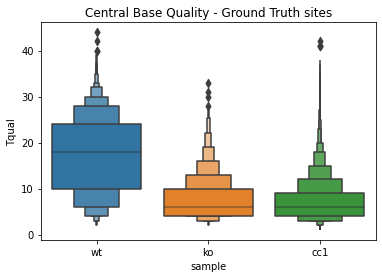

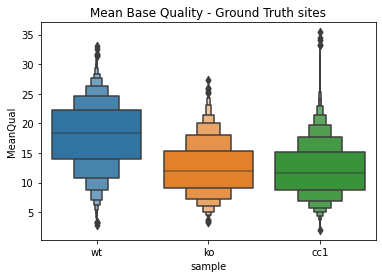

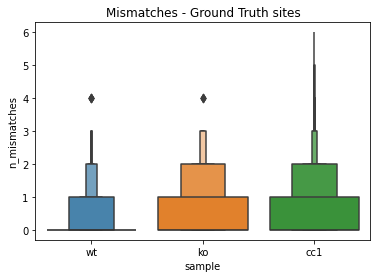

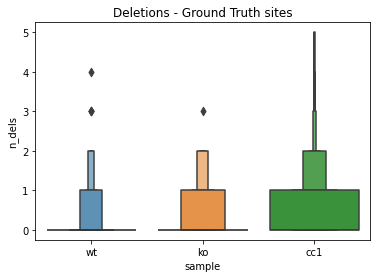

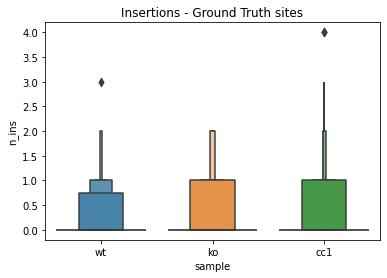

In [17]:
# visualize Tqual and MeanQual
sn.boxenplot(data=dfCT, x="sample", y="Tqual")
plt.title("Central Base Quality - Ground Truth sites")
plt.show()
sn.boxenplot(data=dfCT, x="sample", y="MeanQual")
plt.title("Mean Base Quality - Ground Truth sites")
plt.show()
sn.boxenplot(data=dfCT, x="sample", y="n_mismatches")
plt.title("Mismatches - Ground Truth sites")
plt.show()
sn.boxenplot(data=dfCT, x="sample", y="n_dels")
plt.title("Deletions - Ground Truth sites")
plt.show()
sn.boxenplot(data=dfCT, x="sample", y="n_ins")
plt.title("Insertions - Ground Truth sites")
plt.show()

In [18]:
# visualize all reads in wt with a Tqual higher than 15, a MeanQual higher than 15 and 0 mismatches and indels on genome-space
tqual_ = 15
mq_ = 15
mism_ = 0
ins_ = 0
del_ = 0

print("Ground Truth sites")
print("\n\nwt")
df = dfCT.query("sample == 'wt'").groupby(["region", "position", "strand"]).size().to_frame(name = "T_native").reset_index().describe()["T_native"].to_frame()
df["T_filtered"] = dfCT.query("sample == 'wt'").query(f"n_ins <= {ins_}").query(f"n_mismatches <= {mism_}").query(f"n_dels <= {del_}").query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").groupby(["region", "position", "strand"]).size().to_frame(name = "T_filtered").reset_index().describe()["T_filtered"].values
print("Number of WT reads remaining after indels, mismatches and quality filters on Ground Truth sites:", dfCT.query("sample == 'wt'").query(f"n_ins <= {ins_}").query(f"n_mismatches <= {mism_}").query(f"n_dels <= {del_}").query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").shape[0])
print("Percentage of WT reads remaining after indels, mismatches and quality filters on the CT dataset (wt+ko+cc1) on Ground Truth sites:", dfCT.query("sample == 'wt'").query(f"n_ins <= {ins_}").query(f"n_mismatches <= {mism_}").query(f"n_dels <= {del_}").query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").shape[0] / dfCT.shape[0])
print(df)

print("\n\nko")
df = dfCT.query("sample == 'ko'").groupby(["region", "position", "strand"]).size().to_frame(name = "T_native").reset_index().describe()["T_native"].to_frame()
df["T_filtered"] = dfCT.query("sample == 'ko'").query(f"n_ins <= {ins_}").query(f"n_mismatches <= {mism_}").query(f"n_dels <= {del_}").query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").groupby(["region", "position", "strand"]).size().to_frame(name = "T_filtered").reset_index().describe()["T_filtered"].values
print(df)

print("\n\ncc1")
df = dfCT.query("sample == 'cc1'").groupby(["region", "position", "strand"]).size().to_frame(name = "T_native").reset_index().describe()["T_native"].to_frame()
df["T_filtered"] = dfCT.query("sample == 'cc1'").query(f"n_ins <= {ins_}").query(f"n_mismatches <= {mism_}").query(f"n_dels <= {del_}").query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").groupby(["region", "position", "strand"]).size().to_frame(name = "T_filtered").reset_index().describe()["T_filtered"].values
print(df)

Ground Truth sites


wt
Number of WT reads remaining after indels, mismatches and quality filters on Ground Truth sites: 1909
Percentage of WT reads remaining after indels, mismatches and quality filters on the CT dataset (wt+ko+cc1) on Ground Truth sites: 0.006210513302665739
         T_native  T_filtered
count  244.000000  221.000000
mean    18.405738    8.638009
std     27.470211   14.192354
min      1.000000    1.000000
25%      6.000000    2.000000
50%     10.000000    5.000000
75%     20.250000    9.000000
max    280.000000  150.000000


ko
         T_native  T_filtered
count  226.000000   19.000000
mean     5.526549    1.105263
std      6.605163    0.315302
min      1.000000    1.000000
25%      2.000000    1.000000
50%      3.000000    1.000000
75%      7.000000    1.000000
max     41.000000    2.000000


cc1
          T_native  T_filtered
count  2561.000000  882.000000
mean    117.782897    3.888889
std     224.590933    6.898412
min       1.000000    1.000000
25%      15.0000

In [19]:
def labelling(x, tqual_=tqual_, mq_=mq_, mism_=mism_, del_=del_, ins_=ins_):
    output=0
    read = x.to_list()
    if read[-1] != "wt":
        output = 1
    elif read[-1] == "wt":
        if (read[4]>tqual_)and(read[5]>mq_)and(read[6]<=mism_)and(read[7]<=del_)and(read[8]<=ins_):
            output = -1
        else:
            output = 1
    #print(read, output)
    return output


dfCT["y"] = dfCT.apply(labelling, axis=1)
dfCT

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins,sample,y
0,chr5,32649120,c551ce34-4e7d-4d10-b912-b4ae2742448c,+,21.0,18.7,0,0,0,wt,-1
1,chr5,32649120,2d06b611-c44d-40aa-b79a-246e25df5159,+,7.0,9.0,0,0,0,wt,1
2,chr5,32649120,36a366ef-fe6d-42a3-8b24-d96978e4357a,+,14.0,17.9,1,0,0,wt,1
3,chr5,77114693,e378d9ed-e2f6-4ce1-b746-a816b68ee58e,+,4.0,9.3,1,0,0,wt,1
4,chr5,77114693,d7d57e78-a31d-4695-bfce-d29e48662741,+,7.0,14.1,0,0,0,wt,1
...,...,...,...,...,...,...,...,...,...,...,...
307377,chr2,2484,efeb7f47-9c5e-4956-85e9-b3b0b4acf18a,+,4.0,14.0,0,0,0,cc1,1
307378,chr2,2484,b9e918bf-6122-4fe6-9d37-6300d74b6a9f,+,4.0,16.9,1,0,0,cc1,1
307379,chr2,2484,c3602455-a606-47ba-b4e8-262f5ba058c2,+,16.0,15.3,0,0,0,cc1,1
307380,chr2,2484,ae5805d3-7d4f-44e1-af45-7724f7d87114,+,4.0,10.9,0,0,0,cc1,1


In [20]:
# calculate class composition in percentage
dfCT["y"].value_counts() / dfCT.shape[0] * 100

 1    99.378949
-1     0.621051
Name: y, dtype: float64

In [21]:
# focus on reads without mismatches and indels
dfCT = dfCT.query("n_ins <= 0").query("n_mismatches <= 0").query("n_dels <= 0")
dfCT

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins,sample,y
0,chr5,32649120,c551ce34-4e7d-4d10-b912-b4ae2742448c,+,21.0,18.7,0,0,0,wt,-1
1,chr5,32649120,2d06b611-c44d-40aa-b79a-246e25df5159,+,7.0,9.0,0,0,0,wt,1
4,chr5,77114693,d7d57e78-a31d-4695-bfce-d29e48662741,+,7.0,14.1,0,0,0,wt,1
6,chr5,77114693,c30e8607-3491-4d7b-bfa2-000457f407f8,+,19.0,23.9,0,0,0,wt,-1
7,chr5,77114693,f04ca884-6878-4116-b86d-f7465ecb76ba,+,35.0,28.3,0,0,0,wt,-1
...,...,...,...,...,...,...,...,...,...,...,...
307376,chr2,2484,a3575def-462b-4677-b5ba-c4ddb630800f,+,7.0,20.1,0,0,0,cc1,1
307377,chr2,2484,efeb7f47-9c5e-4956-85e9-b3b0b4acf18a,+,4.0,14.0,0,0,0,cc1,1
307379,chr2,2484,c3602455-a606-47ba-b4e8-262f5ba058c2,+,16.0,15.3,0,0,0,cc1,1
307380,chr2,2484,ae5805d3-7d4f-44e1-af45-7724f7d87114,+,4.0,10.9,0,0,0,cc1,1


In [22]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X = dfCT.iloc[:,4:6]
y_info = dfCT[["region", "position", "strand", "read_name", "sample", "y"]]

# split into train and test sets
X_train, X_test, y_train_info, y_test_info = train_test_split(X, y_info, test_size=0.1)

# print class composition
print(y_train_info["y"].value_counts() / y_train_info.shape[0] * 100)
print()
print(y_test_info["y"].value_counts() / y_test_info.shape[0] * 100)
print()

 1    97.56101
-1     2.43899
Name: y, dtype: float64

 1    97.545699
-1     2.454301
Name: y, dtype: float64



In [23]:
# assess quality composition of test and train after filtering
print("WT train:", X_train.loc[y_train_info.query("sample == 'wt'").index,:].query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").shape[0] / X_train.shape[0] * 100)
print("WT test", X_test.loc[y_test_info.query("sample == 'wt'").index,:].query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").shape[0] / X_test.shape[0] * 100)
mean_contamination = np.mean([X_train.loc[y_train_info.query("sample == 'wt'").index,:].query(f"Tqual > {tqual_}").query(f"MeanQual > {mq_}").shape[0] / X_train.shape[0],
                              X_test.loc[y_test_info.query("sample == 'wt'").index,:].query(f"MeanQual > {mq_}").shape[0] / X_test.shape[0]])
print("Mean Contamination train-test datasets:", mean_contamination)

WT train: 2.438989744026819
WT test 2.454301418893008
Mean Contamination train-test datasets: 0.027534332588215395


In [24]:
# separate info from class label
y_train = y_train_info["y"]
y_test = y_test_info["y"]

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)

# train isolation forest with contamination equal to filtered oxp4 reads count frequency
clf = IsolationForest(contamination=round(mean_contamination,3)*1.5, n_estimators=200, n_jobs=-1, max_samples=1.0, bootstrap=True, verbose=1)
clf.fit(X_train_std)

y_train_info["y_hat"] = clf.predict(X_train_std)
y_train_info

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    0.6s remaining:    9.3s
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    0.9s finished


,region,position,strand,read_name,sample,y,y_hat
162903,chr4,2303,+,06cd4915-62fc-4e85-a779-09da06392816,cc1,1,1
228339,chr3,2222,+,43e180f4-6e3f-4d77-9371-35c0a3bb09c3,cc1,1,1
8834,chr1,181,+,26f1917b-9870-41f4-b3cb-ab67cf25d6cc,cc1,1,1
458,chr6,87976662,-,f91d5787-81a5-457d-8763-f33a0045cd69,wt,-1,-1
203184,chr3,235,+,5cf23950-4eed-4251-8972-a1ad74347883,cc1,1,1
...,...,...,...,...,...,...,...
281996,chr2,1704,+,6e0f0986-5317-40be-8678-241adc6f6c39,cc1,1,1
271607,chr2,1378,+,0bbb8fc2-9b8f-488e-bb0b-3a9f3da920a5,cc1,1,1
217022,chr3,1829,+,a83d0f87-a153-44af-b39f-d18a97dabc5f,cc1,1,1
269006,chr2,1309,+,cd02e193-eac2-40aa-9b21-6ef5289b650a,cc1,1,1


In [25]:
# evaluate accuracy on train set
y_train_info["y_hat"].value_counts() / y_train_info.shape[0] * 100

 1    95.801017
-1     4.198983
Name: y_hat, dtype: float64

In [26]:
# predict on test set
y_test_info["y_hat"] = clf.predict(sc.transform(X_test))

# evaluate accuracy on test set
y_test_info["y_hat"].value_counts() / y_test_info.shape[0] * 100

 1    95.526013
-1     4.473987
Name: y_hat, dtype: float64

In [27]:
df_train = pd.concat([X_train, y_train_info], axis=1)
print("Overview")
print(pd.merge(df_train.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_train.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(),
               how="left").drop(["region", "position", "strand"], axis=1).describe())

print("\n\nwt")
print(pd.merge(df_train.query("sample == 'wt'").groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_train.query("sample == 'wt'").query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(), 
               how="left").drop(["region", "position", "strand"], axis=1).describe())

print("\n\nko")
print(pd.merge(df_train.query("sample == 'ko'").groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_train.query("sample == 'ko'").query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(), 
               how="left").drop(["region", "position", "strand"], axis=1).describe())
print("\n\ncc1")
print(pd.merge(df_train.query("sample == 'cc1'").groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_train.query("sample == 'cc1'").query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(), 
               how="left").drop(["region", "position", "strand"], axis=1).describe())
print()

Overview
          T_native  T_corrected
count  2265.000000   932.000000
mean     31.080795     3.171674
std      83.232927     5.191141
min       1.000000     1.000000
25%       2.000000     1.000000
50%       7.000000     1.000000
75%      23.000000     3.000000
max    1812.000000    75.000000


wt
         T_native  T_corrected
count  233.000000   174.000000
mean    10.905579     4.695402
std     17.798189     7.205833
min      1.000000     1.000000
25%      3.000000     1.250000
50%      6.000000     3.000000
75%     11.000000     4.750000
max    186.000000    74.000000


ko
        T_native  T_corrected
count  82.000000     9.000000
mean    2.878049     1.222222
std     4.134738     0.440959
min     1.000000     1.000000
25%     1.000000     1.000000
50%     2.000000     1.000000
75%     3.000000     1.000000
max    31.000000     2.000000


cc1
          T_native  T_corrected
count  2017.000000   757.000000
mean     33.525533     2.811096
std      87.664717     4.511008
min       

In [28]:
# see anomalies (putative true Ts)
df_train.query("y_hat == -1")[["Tqual", "MeanQual"]].describe()

,Tqual,MeanQual
count,2956.000000,2956.000000
mean,16.554127,19.000135
std,10.704749,8.482464
min,1.000000,2.700000
25%,6.000000,11.000000
50%,17.000000,23.300000
75%,26.250000,25.600000
max,44.000000,35.400000


In [29]:
# see normal observations (false Ts)
df_train.query("y_hat == 1")[["Tqual", "MeanQual"]].describe()

,Tqual,MeanQual
count,67442.000000,67442.000000
mean,7.092865,13.981964
std,4.242737,4.343798
min,2.000000,4.100000
25%,4.000000,10.700000
50%,6.000000,13.900000
75%,9.000000,17.100000
max,31.000000,26.600000


In [30]:
df_test = pd.concat([X_test, y_test_info], axis=1)
print("Overview Test set")
print(pd.merge(df_test.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_test.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(),
               how="left").drop(["region", "position", "strand"], axis=1).describe())

print("\n\nwt")
print(pd.merge(df_test.query("sample == 'wt'").groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_test.query("sample == 'wt'").query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(), 
               how="left").drop(["region", "position", "strand"], axis=1).describe())

print("\n\nko")
print(pd.merge(df_test.query("sample == 'ko'").groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_test.query("sample == 'ko'").query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(), 
               how="left").drop(["region", "position", "strand"], axis=1).describe())
print("\n\ncc1")
print(pd.merge(df_test.query("sample == 'cc1'").groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index(),
               df_test.query("sample == 'cc1'").query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index(), 
               how="left").drop(["region", "position", "strand"], axis=1).describe())
print()

Overview Test set
          T_native  T_corrected
count  1285.000000   239.000000
mean      6.087938     1.464435
std      11.929082     0.960234
min       1.000000     1.000000
25%       1.000000     1.000000
50%       2.000000     1.000000
75%       6.000000     2.000000
max     225.000000     8.000000


wt
         T_native  T_corrected
count  124.000000    58.000000
mean     2.330645     1.551724
std      2.222288     1.062477
min      1.000000     1.000000
25%      1.000000     1.000000
50%      1.000000     1.000000
75%      3.000000     2.000000
max     15.000000     6.000000


ko
        T_native  T_corrected
count  24.000000          0.0
mean    1.291667          NaN
std     0.858673          NaN
min     1.000000          NaN
25%     1.000000          NaN
50%     1.000000          NaN
75%     1.000000          NaN
max     5.000000          NaN


cc1
          T_native  T_corrected
count  1152.000000   181.000000
mean      6.513021     1.436464
std      12.505908     0.926521
m

In [31]:
df_test.query("y_hat == -1")[["Tqual", "MeanQual"]].describe()

,Tqual,MeanQual
count,350.000000,350.000000
mean,15.714286,18.259143
std,10.481725,8.259843
min,1.000000,2.300000
25%,5.000000,11.625000
50%,16.000000,21.900000
75%,25.000000,25.075000
max,42.000000,31.100000


In [32]:
df_test.query("y_hat == 1")[["Tqual", "MeanQual"]].describe()

,Tqual,MeanQual
count,7473.000000,7473.000000
mean,7.074803,13.924675
std,4.152203,4.306883
min,2.000000,4.100000
25%,4.000000,10.700000
50%,6.000000,13.900000
75%,9.000000,17.000000
max,28.000000,26.100000


In [33]:
# save models
from joblib import dump

# save standard scaler
dump(sc, '/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/standard_scaler_no_mims_indels_cc1_wt_ko_21072022.joblib') 

# save iforest trained (no mism. indesl)
dump(clf, "/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/iforest_no_mism_indels_cc1_wt_ko_21072022.joblib")

['/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/iforest_no_mism_indels_cc1_wt_ko_21072022.joblib']

## Prediction on wt_vs_ko murine dataset - Illumina ground truth sites

In [34]:
# load data
col_names = ["region", "position", "read_name", "strand"]+[f"pos{i}" for i in range(-3,4)]+["ins"]
wt_filepaths = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.basecalling_features/wt.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"
ko_filepaths = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.basecalling_features/ko.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"

dfCT_wt = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(wt_filepaths)], axis = 0)
dfCT_ko = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(ko_filepaths)], axis = 0)

In [35]:
dfCT_wt

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,3286403,f3b597d8-2821-4d25-8c35-dc65bcf46e0a,+,7.0,15.0,11.0,4.0,18.0,21.0,30.0,0.0
1,chr5,3286403,244767df-eb4a-40fb-b1da-7cb3a6d792f5,+,6.0,11.0,11.0,9.0,16.0,-11.0,-6.0,0.0
2,chr5,3286407,e8c9bc21-bfb9-47cb-92df-a9ca2f12cc8c,+,6.0,4.0,6.0,7.0,18.0,13.0,-23.0,0.0
3,chr5,3286410,1d0cd8af-4469-447f-807a-05143e9c0325,+,4.0,5.0,6.0,6.0,11.0,9.0,17.0,0.0
4,chr5,3286410,7bf3c277-bb64-4be0-8e49-71a76857728a,+,7.0,4.0,6.0,5.0,13.0,10.0,27.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68451,chr13,120169593,87ea5e75-10e9-4a82-a428-1b070b4b3acc,+,15.0,-0.0,13.0,13.0,15.0,13.0,25.0,0.0
68452,chr13,120169593,4eac5795-fb82-4151-ba25-673385aafcbe,+,13.0,-0.0,18.0,6.0,6.0,9.0,27.0,0.0
68453,chr13,120169593,e0b38f22-c16a-4af7-a006-0f939379379d,+,18.0,-0.0,26.0,4.0,6.0,10.0,19.0,0.0
68454,chr13,120169593,68621b59-d975-492c-8334-dcc133b05434,+,16.0,-0.0,17.0,4.0,13.0,3.0,27.0,0.0


In [36]:
dfCT_ko

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,3286403,0a7afbd1-b00b-4bec-b9e0-f832474c6b74,+,8.0,6.0,6.0,10.0,11.0,-8.0,6.0,0.0
1,chr5,3286406,e9b7aab2-f8b0-41ee-94de-73919661c5e8,+,13.0,-0.0,-0.0,3.0,7.0,8.0,4.0,0.0
2,chr5,3286410,d910bcea-9e54-4420-8f1e-c0d9dbc0d07e,+,18.0,19.0,24.0,20.0,12.0,9.0,19.0,0.0
3,chr5,3286410,c481b263-2d72-45b6-be1b-c9991478fcab,+,7.0,4.0,4.0,17.0,21.0,19.0,25.0,2.0
4,chr5,3286410,a0121be8-92bc-4387-a230-db3823613159,+,12.0,12.0,14.0,6.0,-3.0,18.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
90610,chr13,120169547,2bbf0fbd-2715-4dcf-baa3-950b16ff97ca,+,11.0,15.0,-0.0,5.0,20.0,23.0,21.0,0.0
90611,chr13,120169567,20f16875-1a38-4772-b188-01ddd49a3b05,+,3.0,-0.0,-0.0,6.0,-4.0,5.0,3.0,0.0
90612,chr13,120169593,b478cc97-881b-4272-aee7-8f0a262d3d2c,+,12.0,-0.0,11.0,4.0,10.0,4.0,22.0,0.0
90613,chr13,120169593,31747366-f3b2-49a4-a668-5773e0480ba8,+,9.0,-0.0,12.0,6.0,12.0,10.0,29.0,0.0


In [37]:
# encode basecalling features WT
dfCT_wt_enc = reduce_basecalling_features(dfCT_wt)
dfCT_wt_enc

100%|██████████| 3978426/3978426 [01:41<00:00, 39245.96it/s]


,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,3286403,f3b597d8-2821-4d25-8c35-dc65bcf46e0a,+,4.0,15.1,0,0,0
1,chr5,3286403,244767df-eb4a-40fb-b1da-7cb3a6d792f5,+,9.0,10.0,2,0,0
2,chr5,3286407,e8c9bc21-bfb9-47cb-92df-a9ca2f12cc8c,+,7.0,11.0,1,0,0
3,chr5,3286410,1d0cd8af-4469-447f-807a-05143e9c0325,+,6.0,8.3,0,0,0
4,chr5,3286410,7bf3c277-bb64-4be0-8e49-71a76857728a,+,5.0,10.3,0,0,1
...,...,...,...,...,...,...,...,...,...
3978421,chr13,120169593,87ea5e75-10e9-4a82-a428-1b070b4b3acc,+,13.0,15.7,0,1,0
3978422,chr13,120169593,4eac5795-fb82-4151-ba25-673385aafcbe,+,6.0,13.2,0,1,0
3978423,chr13,120169593,e0b38f22-c16a-4af7-a006-0f939379379d,+,4.0,13.8,0,1,0
3978424,chr13,120169593,68621b59-d975-492c-8334-dcc133b05434,+,4.0,13.3,0,1,0


In [38]:
# encode basecalling features KO
dfCT_ko_enc = reduce_basecalling_features(dfCT_ko)
dfCT_ko_enc

100%|██████████| 5035767/5035767 [02:09<00:00, 38818.99it/s]


,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,3286403,0a7afbd1-b00b-4bec-b9e0-f832474c6b74,+,10.0,7.9,1,0,0
1,chr5,3286406,e9b7aab2-f8b0-41ee-94de-73919661c5e8,+,3.0,7.0,0,2,0
2,chr5,3286410,d910bcea-9e54-4420-8f1e-c0d9dbc0d07e,+,20.0,17.3,0,0,0
3,chr5,3286410,c481b263-2d72-45b6-be1b-c9991478fcab,+,17.0,13.9,0,0,2
4,chr5,3286410,a0121be8-92bc-4387-a230-db3823613159,+,6.0,10.9,1,0,0
...,...,...,...,...,...,...,...,...,...
5035762,chr13,120169547,2bbf0fbd-2715-4dcf-baa3-950b16ff97ca,+,5.0,15.8,0,1,0
5035763,chr13,120169567,20f16875-1a38-4772-b188-01ddd49a3b05,+,6.0,4.2,1,2,0
5035764,chr13,120169593,b478cc97-881b-4272-aee7-8f0a262d3d2c,+,4.0,10.5,0,1,0
5035765,chr13,120169593,31747366-f3b2-49a4-a668-5773e0480ba8,+,6.0,13.0,0,1,0


In [39]:
# delete not encoded basacalling features
del(dfCT_wt)
del(dfCT_ko)

In [40]:
# makes predictions (after mism. indels filtering)
# filtering mism. and indels and store into a filtered dataframe
dfCT_wt_enc_filt = dfCT_wt_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_ko_enc_filt = dfCT_ko_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()

# prediction by iforest
# predict with iforest after scaling to z-scores
dfCT_wt_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_wt_enc_filt.iloc[:,4:6]))
dfCT_ko_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_ko_enc_filt.iloc[:,4:6]))

In [41]:
# print wt filtered
dfCT_wt_enc_filt

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins,y_hat
0,chr5,3286403,f3b597d8-2821-4d25-8c35-dc65bcf46e0a,+,4.0,15.1,0,0,0,1
3,chr5,3286410,1d0cd8af-4469-447f-807a-05143e9c0325,+,6.0,8.3,0,0,0,1
7,chr5,3286410,18194b53-f9d7-4010-af96-dcef88bbca78,+,11.0,11.0,0,0,0,1
9,chr5,3286410,4f84b942-7c15-4f8e-86a3-0015510f79d0,+,4.0,10.3,0,0,0,1
11,chr5,3286410,dabcc8db-d7ae-41a0-a6e8-46a8d4cab85e,+,6.0,13.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3978372,chr13,120169354,13a7771b-b51b-4c3e-8828-916d8e37908f,+,4.0,5.1,0,0,0,1
3978377,chr13,120169370,54242748-3999-4375-9bf8-76ec2eb2764e,+,6.0,12.0,0,0,0,1
3978388,chr13,120169454,54242748-3999-4375-9bf8-76ec2eb2764e,+,6.0,11.4,0,0,0,1
3978389,chr13,120169454,4eac5795-fb82-4151-ba25-673385aafcbe,+,10.0,13.9,0,0,0,1


In [42]:
# print ko filtered
dfCT_ko_enc_filt

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins,y_hat
2,chr5,3286410,d910bcea-9e54-4420-8f1e-c0d9dbc0d07e,+,20.0,17.3,0,0,0,1
18,chr5,3286410,20e42899-d1a0-4781-a759-d3d1edf713c2,+,12.0,10.9,0,0,0,1
20,chr5,3286410,ad5cbf46-19fc-4a38-a2b7-04ecaef13a83,+,4.0,8.0,0,0,0,1
23,chr5,3286410,aebc00a2-a01b-4b30-b9b2-99a7ec1d7aed,+,3.0,11.7,0,0,0,1
28,chr5,3286410,c57226ab-ff32-4cea-9ef4-eb8967578dbb,+,7.0,11.9,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
5035725,chr13,120169232,72123f3a-33a8-4c87-b1b0-0676a673432b,+,7.0,19.1,0,0,0,1
5035744,chr13,120169370,2d472541-7721-4b2c-90f5-154395d6cc0b,+,3.0,7.9,0,0,0,1
5035748,chr13,120169373,67e3d102-b7a2-46ac-b82e-fa178561b0b6,+,5.0,5.3,0,0,0,1
5035749,chr13,120169373,f878370e-7c36-43dd-8c7d-06b27ed44253,+,6.0,11.7,0,0,0,1


In [43]:
dfCT_wt_enc_filt["y_hat"].value_counts()

 1    1019299
-1     105138
Name: y_hat, dtype: int64

In [44]:
dfCT_ko_enc_filt["y_hat"].value_counts()

 1    1262553
-1     125908
Name: y_hat, dtype: int64

In [45]:
dfCT_wt_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  1.051380e+05  1.019299e+06
             mean   7.880297e+07  6.568275e+07
             std    4.786479e+07  4.867032e+07
             min    1.260000e+02  1.150000e+02
             25%    4.132019e+07  2.465272e+07
             50%    8.066841e+07  6.235238e+07
             75%    1.156995e+08  1.025435e+08
             max    1.948123e+08  1.948123e+08
Tqual        count  1.051380e+05  1.019299e+06
             mean   2.207375e+01  7.793636e+00
             std    1.005743e+01  4.855857e+00
             min    1.000000e+00  2.000000e+00
             25%    1.500000e+01  4.000000e+00
             50%    2.500000e+01  6.000000e+00
             75%    2.900000e+01  1.000000e+01
             max    4.600000e+01  3.100000e+01
MeanQual     count  1.051380e+05  1.019299e+06
             mean   2.245028e+01  1.469334e+01
             std    6.626953e+00  4.402931e+00
             min    2.400000e+00  4.100000e+00
             25%    2.010000e+01  1.140000e+01
             50%    2.470000e+01  1.460000e+01
             75%    2.660000e+01  1.800000e+01
             max    3.730000e+01  2.660000e+01
n_mismatches count  1.051380e+05  1.019299e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  1.051380e+05  1.019299e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  1.051380e+05  1.019299e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [46]:
dfCT_ko_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  1.259080e+05  1.262553e+06
             mean   7.967671e+07  7.057346e+07
             std    4.838840e+07  4.849682e+07
             min    2.260000e+02  8.700000e+01
             25%    4.132140e+07  2.882396e+07
             50%    8.271902e+07  6.980801e+07
             75%    1.156995e+08  1.081661e+08
             max    1.948136e+08  1.948136e+08
Tqual        count  1.259080e+05  1.262553e+06
             mean   2.140526e+01  7.706722e+00
             std    1.033353e+01  4.738580e+00
             min    1.000000e+00  2.000000e+00
             25%    1.300000e+01  4.000000e+00
             50%    2.500000e+01  6.000000e+00
             75%    2.900000e+01  1.000000e+01
             max    4.900000e+01  3.100000e+01
MeanQual     count  1.259080e+05  1.262553e+06
             mean   2.248362e+01  1.475006e+01
             std    6.697063e+00  4.386582e+00
             min    2.100000e+00  4.100000e+00
             25%    2.030000e+01  1.140000e+01
             50%    2.470000e+01  1.470000e+01
             75%    2.660000e+01  1.800000e+01
             max    4.000000e+01  2.660000e+01
n_mismatches count  1.259080e+05  1.262553e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  1.259080e+05  1.262553e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  1.259080e+05  1.262553e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [47]:
# aggregate data on genome space before and after correction for both wt and ko samples
dfCT_wt_enc_genomespace_native = dfCT_wt_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_wt_enc_genomespace_native

,region,position,strand,T_native
0,chr1,4846611,-,2
1,chr1,4846619,-,1
2,chr1,4846635,-,5
3,chr1,4846643,-,3
4,chr1,4846645,-,3
...,...,...,...,...
389965,chrY,90804626,+,2
389966,chrY,90804632,+,1
389967,chrY,90804649,+,1
389968,chrY,90804680,+,2


In [48]:
# corrected are both without mism., indels and predcted as novelty by iforest
dfCT_wt_enc_genomespace_corrected = dfCT_wt_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
dfCT_wt_enc_genomespace_corrected

,region,position,strand,T_corrected
0,chr1,4852880,-,1
1,chr1,4855906,-,18
2,chr1,4915375,+,2
3,chr1,4915457,+,1
4,chr1,4915467,+,3
...,...,...,...,...
23732,chrY,20671750,+,30
23733,chrY,20671793,+,1
23734,chrY,20672082,+,21
23735,chrY,90795581,+,1


In [49]:
dfCT_ko_enc_genomespace_native = dfCT_ko_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_ko_enc_genomespace_native

,region,position,strand,T_native
0,chr1,4846611,-,2
1,chr1,4846619,-,2
2,chr1,4846635,-,7
3,chr1,4846643,-,2
4,chr1,4846645,-,4
...,...,...,...,...
527697,chrY,90833612,+,3
527698,chrY,90833626,+,3
527699,chrY,90833629,+,6
527700,chrY,90833633,+,2


In [50]:
dfCT_ko_enc_genomespace_corrected = dfCT_ko_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
dfCT_ko_enc_genomespace_corrected

,region,position,strand,T_corrected
0,chr1,4846915,-,1
1,chr1,4846928,-,1
2,chr1,4855906,-,15
3,chr1,4911322,+,1
4,chr1,4915749,+,1
...,...,...,...,...
26368,chrY,90797180,+,2
26369,chrY,90797198,+,1
26370,chrY,90804632,+,1
26371,chrY,90827645,+,22


In [51]:
# aggregates native and corrected data for WT and KO separately.
dfCT_wt_aggregated = pd.merge(dfCT_wt_enc_genomespace_native, 
                              dfCT_wt_enc_genomespace_corrected,
                              how="left")
dfCT_wt_aggregated.fillna(0, inplace=True)
dfCT_wt_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,4846611,-,2,0.0
1,chr1,4846619,-,1,0.0
2,chr1,4846635,-,5,0.0
3,chr1,4846643,-,3,0.0
4,chr1,4846645,-,3,0.0
...,...,...,...,...,...
389965,chrY,90804626,+,2,0.0
389966,chrY,90804632,+,1,0.0
389967,chrY,90804649,+,1,0.0
389968,chrY,90804680,+,2,0.0


In [52]:
dfCT_ko_aggregated = pd.merge(dfCT_ko_enc_genomespace_native, 
                              dfCT_ko_enc_genomespace_corrected,
                              how="left")
dfCT_ko_aggregated.fillna(0, inplace=True)
dfCT_ko_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,4846611,-,2,0.0
1,chr1,4846619,-,2,0.0
2,chr1,4846635,-,7,0.0
3,chr1,4846643,-,2,0.0
4,chr1,4846645,-,4,0.0
...,...,...,...,...,...
527697,chrY,90833612,+,3,0.0
527698,chrY,90833626,+,3,0.0
527699,chrY,90833629,+,6,0.0
527700,chrY,90833633,+,2,0.0


In [53]:
dfCT_wt_aggregated.describe()

,position,T_native,T_corrected
count,3.899700e+05,389970.000000,389970.000000
mean,7.923449e+07,10.201877,0.269605
std,4.535063e+07,53.217195,10.531236
min,1.130000e+02,1.000000,0.000000
25%,3.891144e+07,1.000000,0.000000
50%,7.969981e+07,3.000000,0.000000
75%,1.159316e+08,6.000000,0.000000
max,1.948123e+08,5792.000000,3575.000000


In [54]:
dfCT_ko_aggregated.describe()

,position,T_native,T_corrected
count,5.277020e+05,527702.000000,527702.000000
mean,7.907712e+07,9.542823,0.238597
std,4.579176e+07,50.415169,9.880713
min,8.700000e+01,1.000000,0.000000
25%,3.770223e+07,1.000000,0.000000
50%,7.915740e+07,3.000000,0.000000
75%,1.164971e+08,6.000000,0.000000
max,1.948136e+08,8112.000000,3233.000000


In [55]:
# focus on illumina ground truth sites
ill_col_names = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39_columns.txt", header=None)
illumina_gt_mouse = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39.txt", header=None, names=ill_col_names[0].to_list())
illumina_gt_mouse

,contig_mm39,pos_mm39,contig_mm10,pos_mm10,ref_base,strand,cov_WT,MeanQual_WT,"BaseCount_WT[A,C,G,T]",Subs_WT,SubsFreq_WT,cov_KO,MeanQual_KO,"BaseCount_KO[A,C,G,T]",Subs_KO,SubsFreq_KO,PositionAnnotation,gene_name
0,chr1,4915683,chr1,4845460,C,1,290,35.40,"[0, 258, 0, 32]",CT,0.11,184,35.08,"[0, 184, 0, 0]",-,0.0,UTR3,Lypla1
1,chr1,4915694,chr1,4845471,C,1,290,35.45,"[0, 258, 0, 32]",CT,0.11,183,35.54,"[0, 183, 0, 0]",-,0.0,UTR3,Lypla1
2,chr1,4915851,chr1,4845628,C,1,142,35.19,"[0, 135, 0, 7]",CT,0.05,83,35.00,"[0, 83, 0, 0]",-,0.0,UTR3,Lypla1
3,chr1,4916384,chr1,4846161,C,1,183,35.79,"[0, 164, 0, 19]",CT,0.10,134,35.85,"[0, 134, 0, 0]",-,0.0,UTR3,Lypla1
4,chr1,4967044,chr1,4896821,C,1,439,35.51,"[0, 404, 0, 35]",CT,0.08,325,35.56,"[0, 325, 0, 0]",-,0.0,UTR3,Tcea1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,chrX,166129481,chrX,167346485,C,0,125,35.35,"[0, 119, 0, 6]",CT,0.05,86,35.72,"[0, 86, 0, 0]",-,0.0,UTR3,Prps2
683,chrX,166130959,chrX,167347963,C,0,70,35.71,"[0, 66, 0, 4]",CT,0.06,70,35.58,"[0, 70, 0, 0]",-,0.0,UTR3,Prps2
684,chrX,166131073,chrX,167348077,C,0,116,35.45,"[0, 110, 0, 6]",CT,0.05,128,35.77,"[0, 128, 0, 0]",-,0.0,UTR3,Prps2
685,chrX,166131296,chrX,167348300,C,0,133,35.46,"[0, 120, 0, 13]",CT,0.10,102,35.44,"[0, 102, 0, 0]",-,0.0,UTR3,Prps2


In [56]:
import pysam

# for wt
dfCT_wt_aggregated_gt = pd.merge(illumina_gt_mouse[["contig_mm39", "pos_mm39", "strand"]],
                                 dfCT_wt_aggregated,
                                 how="left", 
                                 right_on=["region", "position"],
                                 left_on=["contig_mm39", "pos_mm39"]).drop(["region", "position"], axis=1)

dfCT_wt_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_wt_aggregated_gt["strand_reditools"] = dfCT_wt_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_wt_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_wt_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_wt_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_wt_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_wt_aggregated_gt = dfCT_wt_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_wt_aggregated_gt["Tfreq_native"] = dfCT_wt_aggregated_gt["T_native"] / dfCT_wt_aggregated_gt["depth_stranded"]
dfCT_wt_aggregated_gt["Tfreq_corrected"] = dfCT_wt_aggregated_gt["T_corrected"] / dfCT_wt_aggregated_gt["depth_stranded"]
dfCT_wt_aggregated_gt

100%|██████████| 687/687 [00:15<00:00, 44.28it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,4915683,+,7.0,0.0,54,0.129630,0.000000
1,chr1,4915694,+,7.0,3.0,51,0.137255,0.058824
2,chr1,4915851,+,0.0,0.0,59,0.000000,0.000000
3,chr1,4916384,+,13.0,2.0,65,0.200000,0.030769
4,chr1,4967044,+,10.0,5.0,106,0.094340,0.047170
...,...,...,...,...,...,...,...,...
660,chrX,108204953,+,7.0,2.0,72,0.097222,0.027778
661,chrX,108205780,+,12.0,3.0,99,0.121212,0.030303
662,chrX,133507395,+,10.0,3.0,55,0.181818,0.054545
664,chrX,135147837,+,11.0,3.0,52,0.211538,0.057692


In [57]:
dfCT_wt_aggregated_gt.describe()

,position,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
count,2.430000e+02,243.000000,243.00000,243.000000,243.000000,243.000000
mean,7.429018e+07,18.358025,3.72428,140.358025,0.118708,0.023923
std,4.447930e+07,27.542593,7.07239,137.598107,0.085258,0.026800
min,4.183575e+06,0.000000,0.00000,51.000000,0.000000,0.000000
25%,3.750864e+07,6.000000,0.00000,70.000000,0.062554,0.000000
50%,7.161833e+07,10.000000,2.00000,100.000000,0.106383,0.015748
75%,1.082045e+08,20.000000,4.00000,143.000000,0.151861,0.037037
max,1.821040e+08,280.000000,80.00000,1042.000000,0.629032,0.180077


In [58]:
# for ko
dfCT_ko_aggregated_gt = pd.merge(illumina_gt_mouse[["contig_mm39", "pos_mm39", "strand"]],
                                 dfCT_ko_aggregated,
                                 how="left", 
                                 right_on=["region", "position"],
                                 left_on=["contig_mm39", "pos_mm39"]).drop(["region", "position"], axis=1)

dfCT_ko_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_ko_aggregated_gt["strand_reditools"] = dfCT_ko_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_ko_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_ko_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_ko_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_ko_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_ko_aggregated_gt = dfCT_ko_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_ko_aggregated_gt["Tfreq_native"] = dfCT_ko_aggregated_gt["T_native"] / dfCT_ko_aggregated_gt["depth_stranded"]
dfCT_ko_aggregated_gt["Tfreq_corrected"] = dfCT_ko_aggregated_gt["T_corrected"] / dfCT_ko_aggregated_gt["depth_stranded"]
dfCT_ko_aggregated_gt

100%|██████████| 687/687 [00:17<00:00, 39.00it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,4915683,+,3.0,0.0,81,0.037037,0.0
1,chr1,4915694,+,7.0,0.0,83,0.084337,0.0
2,chr1,4915851,+,0.0,0.0,89,0.000000,0.0
3,chr1,4916384,+,4.0,0.0,99,0.040404,0.0
4,chr1,4967044,+,4.0,0.0,123,0.032520,0.0
...,...,...,...,...,...,...,...,...
660,chrX,108204953,+,3.0,0.0,111,0.027027,0.0
661,chrX,108205780,+,1.0,0.0,141,0.007092,0.0
662,chrX,133507395,+,0.0,0.0,56,0.000000,0.0
666,chrX,139376667,+,0.0,0.0,56,0.000000,0.0


In [59]:
dfCT_ko_aggregated_gt.describe()

,position,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
count,2.920000e+02,292.000000,292.000000,292.000000,292.000000,292.000000
mean,7.333500e+07,4.178082,0.037671,145.390411,0.031371,0.000213
std,4.352282e+07,6.202965,0.223880,144.517416,0.039696,0.001609
min,4.105936e+06,0.000000,0.000000,51.000000,0.000000,0.000000
25%,3.745671e+07,1.000000,0.000000,69.750000,0.003830,0.000000
50%,7.161832e+07,2.000000,0.000000,103.500000,0.017544,0.000000
75%,1.082039e+08,5.000000,0.000000,165.750000,0.042443,0.000000
max,1.821040e+08,41.000000,2.000000,1473.000000,0.271523,0.022222


In [61]:
# save to disk reads prediction
dfCT_wt_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_wt.tsv", 
                   sep="\t",
                   index=None)
dfCT_ko_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_ko.tsv", 
                   sep="\t",
                   index=None)
# save genome space aggregated data
dfCT_wt_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_wt_ill_gt.tsv",
                             sep="\t",
                             index=None)
dfCT_ko_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_ko_ill_gt.tsv",
                             sep="\t",
                             index=None)

In [62]:
# compute some metrics
from sklearn.metrics import classification_report, precision_score, accuracy_score, f1_score, confusion_matrix, recall_score

threshold = 0.01

y_illumina = []
y_native = []
y_corrected = []

# for WT sites
for s in dfCT_wt_aggregated_gt.itertuples():
    y_illumina.append(1)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)
    
# for KO sites
for s in dfCT_ko_aggregated_gt.itertuples():
    y_illumina.append(0)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)

print(len(y_illumina))
print(len(y_native))
print(len(y_corrected))

535
535
535


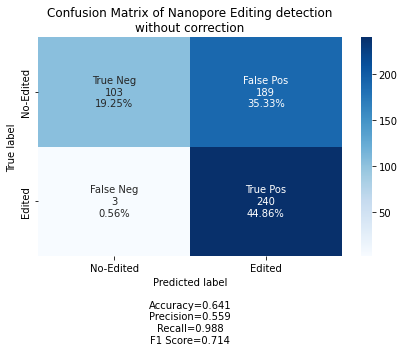

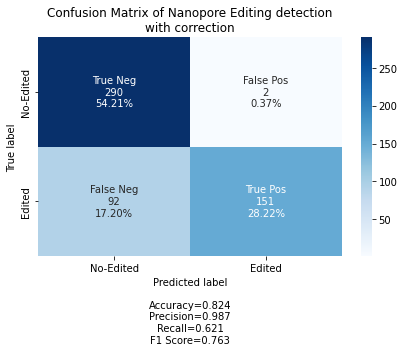

In [63]:
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["No-Edited", "Edited"]

# confusion matrices plots
utils.make_confusion_matrix(confusion_matrix(y_illumina, y_native), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of Nanopore Editing detection\nwithout correction",
                      figsize=(6,5), 
                      path="/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/ConfMatrix_wt_vs_ko_NoCorrection.tiff")

utils.make_confusion_matrix(confusion_matrix(y_illumina, y_corrected), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of Nanopore Editing detection\nwith correction",
                      figsize=(6,5),
                      path="/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/ConfMatrix_wt_vs_ko_iForestCorrection.tiff")

In [64]:
print("ONT Native")
print(classification_report(y_illumina, y_native))
print("Accuracy:", accuracy_score(y_illumina, y_native))
print("Recall:", recall_score(y_illumina, y_native))
print("Precision:", precision_score(y_illumina, y_native))
print("F1-score:", f1_score(y_illumina, y_native))
tn, fp, fn, tp = confusion_matrix(y_illumina, y_native).ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)
print()
print("ONT Corrected")
print(classification_report(y_illumina, y_corrected))
print("Accuracy:", accuracy_score(y_illumina, y_corrected))
print("Recall:", recall_score(y_illumina, y_corrected))
print("Precision:", precision_score(y_illumina, y_corrected))
print("F1-score:", f1_score(y_illumina, y_corrected))
tn, fp, fn, tp = confusion_matrix(y_illumina, y_corrected).ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)
print()

ONT Native
              precision    recall  f1-score   support

           0       0.97      0.35      0.52       292
           1       0.56      0.99      0.71       243

    accuracy                           0.64       535
   macro avg       0.77      0.67      0.62       535
weighted avg       0.78      0.64      0.61       535

Accuracy: 0.6411214953271028
Recall: 0.9876543209876543
Precision: 0.5594405594405595
F1-score: 0.7142857142857142
Specificity: 0.3527397260273973

ONT Corrected
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       292
           1       0.99      0.62      0.76       243

    accuracy                           0.82       535
   macro avg       0.87      0.81      0.81       535
weighted avg       0.86      0.82      0.82       535

Accuracy: 0.8242990654205608
Recall: 0.6213991769547325
Precision: 0.9869281045751634
F1-score: 0.7626262626262625
Specificity: 0.9931506849315068



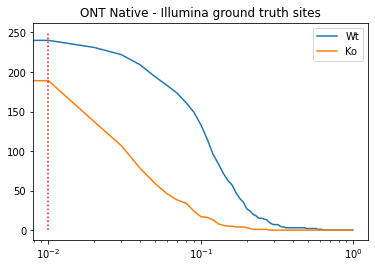

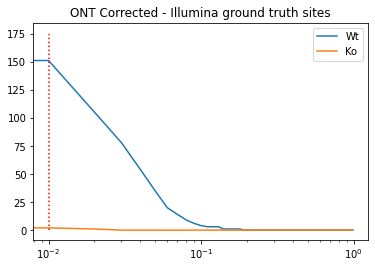

In [65]:
thrs = []
wts = []
kos = []
for i in np.arange(0,1, 0.01):
    thrs.append(i)
    wts.append(dfCT_wt_aggregated_gt.query(f"Tfreq_native > {i}").shape[0])
    kos.append(dfCT_ko_aggregated_gt.query(f"Tfreq_native > {i}").shape[0])

plt.figure()
plt.title("ONT Native - Illumina ground truth sites")
plt.plot(thrs, wts, label="Wt")
plt.plot(thrs, kos, label="Ko")
plt.legend()
plt.vlines(0.01, 0, 250, colors="r", linestyles="dotted")
plt.xscale("log")
plt.show()

thrs = []
wts = []
kos = []

for i in np.arange(0,1, 0.01):
    thrs.append(i)
    wts.append(dfCT_wt_aggregated_gt.query(f"Tfreq_corrected > {i}").shape[0])
    kos.append(dfCT_ko_aggregated_gt.query(f"Tfreq_corrected > {i}").shape[0])

plt.figure()
plt.title("ONT Corrected - Illumina ground truth sites")
plt.plot(thrs, wts, label="Wt")
plt.plot(thrs, kos, label="Ko")
plt.legend()
plt.vlines(0.01, 0, 175, colors="r", linestyles="dotted")
plt.xscale("log")
plt.show()

## Prediction on wt_vs_oxp human dataset - Illumina ground truth sites

In [66]:
# load data
wt1_filepaths = "/lustre/bio_running/conticello/wt1/wt1.basecalling_features/wt1.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"
wt4_filepaths = "/lustre/bio_running/conticello/wt4/wt4.basecalling_features/wt4.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"
oxp1_filepaths = "/lustre/bio_running/conticello/oxp1/oxp1.basecalling_features/oxp1.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"
oxp2_filepaths = "/lustre/bio_running/conticello/oxp2/oxp2.basecalling_features/oxp2.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"
oxp3_filepaths = "/lustre/bio_running/conticello/oxp3/oxp3.basecalling_features/oxp3.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"
oxp4_filepaths = "/lustre/bio_running/conticello/oxp4/oxp4.basecalling_features/oxp4.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*"

dfCT_wt1 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(wt1_filepaths)], axis = 0)
dfCT_wt4 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(wt4_filepaths)], axis = 0)
dfCT_oxp1 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(oxp1_filepaths)], axis = 0)
dfCT_oxp2 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(oxp2_filepaths)], axis = 0)
dfCT_oxp3 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(oxp3_filepaths)], axis = 0)
dfCT_oxp4 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in glob.glob(oxp4_filepaths)], axis = 0)

In [90]:
# total number of CT reads retrieved with a depth higher than 50
dfCT_wt1

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,204977,b74a2e71-91a2-4b28-b84d-1d5b26a2d282,-,7.0,24.0,-5.0,2.0,4.0,4.0,5.0,0.0
1,chr5,205023,458ad779-c42b-4fae-ac0b-6a5697ea708c,-,14.0,17.0,10.0,7.0,7.0,16.0,26.0,0.0
2,chr5,205023,086b13c3-b271-44af-bd2e-972b64080d33,-,-2.0,-3.0,3.0,6.0,3.0,10.0,18.0,0.0
3,chr5,205023,8d77acb9-75ff-4895-9b66-c9b2b58edcb0,-,18.0,13.0,14.0,10.0,6.0,12.0,8.0,0.0
4,chr5,205025,51c50891-27e3-4f42-a3d2-dc7fb58e69aa,-,-0.0,4.0,6.0,3.0,-6.0,10.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
81200,chr13,113641456,8430698f-cdf0-4535-8b83-9dee216fa912,+,-0.0,7.0,2.0,3.0,3.0,8.0,3.0,0.0
81201,chr13,113641456,8c11fa4a-53d3-4104-a554-50052ec11161,+,-0.0,4.0,3.0,9.0,5.0,-0.0,-13.0,0.0
81202,chr13,113641456,d111dfc4-3e64-4e07-964c-62f415b7baf3,+,15.0,6.0,6.0,4.0,-6.0,11.0,8.0,0.0
81203,chr13,113641456,6c83eada-d2c1-4397-9628-4d3f84b3bb7a,+,-0.0,3.0,2.0,2.0,5.0,4.0,3.0,0.0


In [91]:
# total number of sites with at least one CT context read
dfCT_wt1.groupby(["region", "position", "strand"]).size().to_frame("Tnative").reset_index().shape

(1025820, 4)

In [92]:
# total number of CT reads retrieved with a depth higher than 50
dfCT_wt4

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,218348,737c20a8-2218-4fe2-a0dd-44a7019de03d,+,24.0,-0.0,13.0,6.0,16.0,14.0,16.0,0.0
1,chr5,218351,7dc9a1f7-fb86-48a6-9d70-68cf29ed26ef,+,10.0,12.0,-9.0,10.0,28.0,23.0,24.0,0.0
2,chr5,218351,d8ad0441-1d41-4f12-9270-a18efedd2a53,+,14.0,7.0,-6.0,10.0,8.0,9.0,14.0,0.0
3,chr5,218351,db9d84ae-cf3e-4448-a7e8-5cfa61bfc5eb,+,7.0,-0.0,-0.0,10.0,12.0,20.0,11.0,0.0
4,chr5,218351,d848474d-6354-4a29-bd7d-f863ba462259,+,12.0,7.0,-6.0,6.0,22.0,22.0,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35980,chr13,113641456,c3efb990-4d4e-4078-b24c-ca0a6fd4a1a6,+,-0.0,5.0,3.0,6.0,6.0,12.0,3.0,0.0
35981,chr13,113641456,7f218807-45e4-4af9-8038-01378e6f13fc,+,3.0,-2.0,2.0,4.0,3.0,5.0,5.0,1.0
35982,chr13,113641456,c311482b-acb8-49d5-8ba5-952ef4575267,+,12.0,3.0,-4.0,3.0,3.0,-5.0,15.0,0.0
35983,chr13,113641456,bcedb271-b4bd-4cee-86b7-b39473e1e604,+,2.0,5.0,4.0,2.0,-3.0,-8.0,14.0,0.0


In [93]:
# total number of sites with at least one CT context read
dfCT_wt4.groupby(["region", "position", "strand"]).size().to_frame("Tnative").reset_index().shape

(536629, 4)

In [94]:
# total number of CT reads retrieved with a depth higher than 50
dfCT_oxp1

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,236439,d7fa05dc-edda-48d4-b6b3-f7663c712c5e,+,21.0,12.0,-10.0,4.0,-2.0,5.0,5.0,0.0
1,chr5,236439,e4fcd0cb-8959-460f-ae78-6d3c3bda162d,+,18.0,10.0,-0.0,8.0,-8.0,22.0,23.0,0.0
2,chr5,236475,be9ec7f7-d285-4565-921e-217f1a16f923,+,8.0,7.0,9.0,12.0,13.0,23.0,7.0,1.0
3,chr5,236475,73cb1acf-d599-4d16-9051-7517e1e8d39a,+,27.0,8.0,3.0,3.0,3.0,22.0,20.0,0.0
4,chr5,236475,57c4abe0-6d5d-4fce-ab5c-7ca93ba51cf0,+,19.0,9.0,-3.0,3.0,4.0,12.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10987,chr13,113323418,b63e2c2b-e5e4-4b7e-aea2-85de5a70faa8,+,18.0,11.0,7.0,13.0,6.0,28.0,28.0,0.0
10988,chr13,113323418,19e10761-01d1-4d79-b992-4357669c0968,+,21.0,17.0,5.0,5.0,8.0,11.0,8.0,0.0
10989,chr13,113323418,a2606a5c-a2e3-437d-b27b-7b98e4985134,+,17.0,6.0,6.0,6.0,5.0,19.0,11.0,0.0
10990,chr13,113323418,e7df1084-3d25-4a48-a959-e339ab7e736c,+,22.0,19.0,14.0,5.0,20.0,4.0,7.0,0.0


In [95]:
# total number of sites with at least one CT context read
dfCT_oxp1.groupby(["region", "position", "strand"]).size().to_frame("Tnative").reset_index().shape

(182799, 4)

In [96]:
# total number of CT reads retrieved with a depth higher than 50
dfCT_oxp2

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,235147,e20ea862-12a6-42d1-b24d-ad79744bf6e1,+,-0.0,-0.0,-0.0,5.0,4.0,6.0,10.0,0.0
1,chr5,235178,7f44b0f9-ac5c-4443-b7b6-20a8235c5f60,+,13.0,14.0,6.0,4.0,15.0,22.0,17.0,0.0
2,chr5,235178,b1116248-ad25-4495-aa61-7b3719068036,+,22.0,-20.0,18.0,9.0,29.0,26.0,17.0,0.0
3,chr5,235178,2c121d4c-7ac2-464c-a87d-d4e452f0ab30,+,10.0,14.0,-3.0,5.0,24.0,21.0,20.0,1.0
4,chr5,235178,d99b8b10-2397-4621-9031-28368dbb1486,+,5.0,-4.0,-3.0,4.0,11.0,18.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7842,chr13,75537824,ddbf5bc1-c395-48f1-bffa-e5a3f725ab14,-,20.0,14.0,-3.0,2.0,6.0,15.0,15.0,0.0
7843,chr13,75537824,fdeb48db-f383-4fe8-b47d-58de59ba3059,-,17.0,11.0,-7.0,3.0,15.0,20.0,22.0,0.0
7844,chr13,75537824,df96985d-44b8-4597-a228-3c837058abb7,-,26.0,25.0,20.0,8.0,-8.0,22.0,29.0,0.0
7845,chr13,75537824,9f44ac1d-3426-4bc0-863d-b4cadadc7c86,-,19.0,5.0,2.0,2.0,5.0,16.0,16.0,0.0


In [97]:
# total number of sites with at least one CT context read
dfCT_oxp2.groupby(["region", "position", "strand"]).size().to_frame("Tnative").reset_index().shape

(271006, 4)

In [98]:
# total number of CT reads retrieved with a depth higher than 50
dfCT_oxp3

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,40832471,f15d715a-34db-4556-837d-bb02d0b0aaf3,-,14.0,7.0,-4.0,5.0,6.0,10.0,5.0,0.0
1,chr5,40832471,f9de4be0-b766-4409-ab58-3cb611a93884,-,16.0,19.0,10.0,5.0,19.0,22.0,17.0,0.0
2,chr5,40832471,106a7fce-ed4d-4fdc-9e74-bb09a3ea6513,-,7.0,-6.0,-10.0,11.0,6.0,5.0,3.0,0.0
3,chr5,40832471,72a6aa02-e991-408e-9c13-bcbaf0160b89,-,19.0,-3.0,17.0,3.0,11.0,11.0,9.0,0.0
4,chr5,40832471,4917e791-5116-4278-9513-49117b6701b2,-,18.0,4.0,-6.0,16.0,19.0,20.0,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
642,chr13,45341159,49d05444-49a4-4a3b-ac8a-b29071db4196,-,8.0,19.0,16.0,3.0,-0.0,-0.0,-0.0,0.0
643,chr13,45341159,65a57fab-92d4-47f1-b08d-49d8a86adce3,-,14.0,17.0,16.0,8.0,-0.0,-0.0,11.0,0.0
644,chr13,45341159,bac072e9-9e1f-4c88-b333-e5e88d1c402e,-,21.0,15.0,14.0,7.0,8.0,-0.0,17.0,0.0
645,chr13,45341162,c0b71d6e-cf34-479b-82b7-85d7877b27e8,-,20.0,7.0,9.0,9.0,15.0,17.0,22.0,0.0


In [99]:
# total number of sites with at least one CT context read
dfCT_oxp3.groupby(["region", "position", "strand"]).size().to_frame("Tnative").reset_index().shape

(34167, 4)

In [100]:
# total number of CT reads retrieved with a depth higher than 50
dfCT_oxp4

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr5,1801435,7d6b3328-0ba4-4f0f-9712-c84477b9c7d4,+,27.0,24.0,10.0,3.0,8.0,-3.0,10.0,0.0
1,chr5,1801438,27b0aaa9-d854-4a02-aa21-4eb161e18fbf,+,10.0,11.0,28.0,4.0,25.0,25.0,24.0,0.0
2,chr5,1801438,ec7aaee7-d693-49c5-aca7-e5384906edac,+,7.0,7.0,-4.0,5.0,15.0,15.0,20.0,0.0
3,chr5,1801438,7fd7cede-3724-424a-93af-c730410b2c55,+,5.0,-4.0,-4.0,8.0,6.0,10.0,12.0,0.0
4,chr5,1801438,9636a731-17f4-41e2-8b10-ab54e06e4685,+,19.0,5.0,29.0,10.0,19.0,20.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1554,chr13,45341159,f39d993d-74fc-446f-8f3d-80ab7f4131d4,-,26.0,13.0,13.0,10.0,-0.0,-0.0,7.0,0.0
1555,chr13,45341159,db5fe2a2-1e2d-4628-885b-c1b6f8149758,-,5.0,14.0,14.0,3.0,-0.0,-0.0,12.0,0.0
1556,chr13,45341162,675d27d9-a288-4988-a1a3-50c1b203be93,-,26.0,20.0,12.0,10.0,10.0,11.0,17.0,0.0
1557,chr13,45341162,e7d096a3-1b90-4140-b8b0-74c843aeacd9,-,29.0,22.0,17.0,18.0,4.0,20.0,19.0,0.0


In [101]:
# total number of sites with at least one CT context read
dfCT_oxp4.groupby(["region", "position", "strand"]).size().to_frame("Tnative").reset_index().shape

(54185, 4)

In [102]:
# encode and reduce basecalling features
dfCT_wt1_enc = reduce_basecalling_features(dfCT_wt1)
dfCT_wt4_enc = reduce_basecalling_features(dfCT_wt4)
dfCT_oxp1_enc = reduce_basecalling_features(dfCT_oxp1)
dfCT_oxp2_enc = reduce_basecalling_features(dfCT_oxp2)
dfCT_oxp3_enc = reduce_basecalling_features(dfCT_oxp3)
dfCT_oxp4_enc = reduce_basecalling_features(dfCT_oxp4)

100%|██████████| 685565/685565 [00:17<00:00, 38285.71it/s]


In [103]:
# delete starting basecalling features to spare memory
del(dfCT_wt1)
del(dfCT_wt4)
del(dfCT_oxp1)
del(dfCT_oxp2)
del(dfCT_oxp3)
del(dfCT_oxp4)

In [104]:
dfCT_wt1_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,204977,b74a2e71-91a2-4b28-b84d-1d5b26a2d282,-,2.0,7.3,1,0,0
1,chr5,205023,458ad779-c42b-4fae-ac0b-6a5697ea708c,-,7.0,13.9,0,0,0
2,chr5,205023,086b13c3-b271-44af-bd2e-972b64080d33,-,6.0,6.4,2,0,0
3,chr5,205023,8d77acb9-75ff-4895-9b66-c9b2b58edcb0,-,10.0,11.6,0,0,0
4,chr5,205025,51c50891-27e3-4f42-a3d2-dc7fb58e69aa,-,3.0,6.5,1,1,0
...,...,...,...,...,...,...,...,...,...
11144175,chr13,113641456,8430698f-cdf0-4535-8b83-9dee216fa912,+,3.0,4.3,0,1,0
11144176,chr13,113641456,8c11fa4a-53d3-4104-a554-50052ec11161,+,9.0,6.8,1,2,0
11144177,chr13,113641456,d111dfc4-3e64-4e07-964c-62f415b7baf3,+,4.0,8.0,1,0,0
11144178,chr13,113641456,6c83eada-d2c1-4397-9628-4d3f84b3bb7a,+,2.0,3.2,0,1,0


In [105]:
dfCT_wt4_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,218348,737c20a8-2218-4fe2-a0dd-44a7019de03d,+,6.0,14.8,0,1,0
1,chr5,218351,7dc9a1f7-fb86-48a6-9d70-68cf29ed26ef,+,10.0,16.6,1,0,0
2,chr5,218351,d8ad0441-1d41-4f12-9270-a18efedd2a53,+,10.0,9.7,1,0,0
3,chr5,218351,db9d84ae-cf3e-4448-a7e8-5cfa61bfc5eb,+,10.0,12.0,0,2,0
4,chr5,218351,d848474d-6354-4a29-bd7d-f863ba462259,+,6.0,13.1,1,0,0
...,...,...,...,...,...,...,...,...,...
6116327,chr13,113641456,c3efb990-4d4e-4078-b24c-ca0a6fd4a1a6,+,6.0,5.8,0,1,0
6116328,chr13,113641456,7f218807-45e4-4af9-8038-01378e6f13fc,+,4.0,3.4,1,0,1
6116329,chr13,113641456,c311482b-acb8-49d5-8ba5-952ef4575267,+,3.0,6.4,2,0,0
6116330,chr13,113641456,bcedb271-b4bd-4cee-86b7-b39473e1e604,+,2.0,5.4,2,0,0


In [106]:
dfCT_oxp1_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,236439,d7fa05dc-edda-48d4-b6b3-f7663c712c5e,+,4.0,8.4,2,0,0
1,chr5,236439,e4fcd0cb-8959-460f-ae78-6d3c3bda162d,+,8.0,14.8,1,1,0
2,chr5,236475,be9ec7f7-d285-4565-921e-217f1a16f923,+,12.0,11.3,0,0,1
3,chr5,236475,73cb1acf-d599-4d16-9051-7517e1e8d39a,+,3.0,12.3,0,0,0
4,chr5,236475,57c4abe0-6d5d-4fce-ab5c-7ca93ba51cf0,+,3.0,8.0,1,0,0
...,...,...,...,...,...,...,...,...,...
2121105,chr13,113323418,b63e2c2b-e5e4-4b7e-aea2-85de5a70faa8,+,13.0,15.9,0,0,0
2121106,chr13,113323418,19e10761-01d1-4d79-b992-4357669c0968,+,5.0,10.7,0,0,0
2121107,chr13,113323418,a2606a5c-a2e3-437d-b27b-7b98e4985134,+,6.0,10.0,0,0,0
2121108,chr13,113323418,e7df1084-3d25-4a48-a959-e339ab7e736c,+,5.0,13.0,0,0,0


In [107]:
dfCT_oxp2_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,235147,e20ea862-12a6-42d1-b24d-ad79744bf6e1,+,5.0,6.2,0,3,0
1,chr5,235178,7f44b0f9-ac5c-4443-b7b6-20a8235c5f60,+,4.0,13.0,0,0,0
2,chr5,235178,b1116248-ad25-4495-aa61-7b3719068036,+,9.0,20.1,1,0,0
3,chr5,235178,2c121d4c-7ac2-464c-a87d-d4e452f0ab30,+,5.0,13.9,1,0,1
4,chr5,235178,d99b8b10-2397-4621-9031-28368dbb1486,+,4.0,7.6,2,0,0
...,...,...,...,...,...,...,...,...,...
2982417,chr13,75537824,ddbf5bc1-c395-48f1-bffa-e5a3f725ab14,-,2.0,10.7,1,0,0
2982418,chr13,75537824,fdeb48db-f383-4fe8-b47d-58de59ba3059,-,3.0,13.6,1,0,0
2982419,chr13,75537824,df96985d-44b8-4597-a228-3c837058abb7,-,8.0,19.7,1,0,0
2982420,chr13,75537824,9f44ac1d-3426-4bc0-863d-b4cadadc7c86,-,2.0,9.3,0,0,0


In [108]:
dfCT_oxp3_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,40832471,f15d715a-34db-4556-837d-bb02d0b0aaf3,-,5.0,7.3,1,0,0
1,chr5,40832471,f9de4be0-b766-4409-ab58-3cb611a93884,-,5.0,15.4,0,0,0
2,chr5,40832471,106a7fce-ed4d-4fdc-9e74-bb09a3ea6513,-,11.0,6.9,2,0,0
3,chr5,40832471,72a6aa02-e991-408e-9c13-bcbaf0160b89,-,3.0,10.4,1,0,0
4,chr5,40832471,4917e791-5116-4278-9513-49117b6701b2,-,16.0,14.3,1,0,0
...,...,...,...,...,...,...,...,...,...
398856,chr13,45341159,49d05444-49a4-4a3b-ac8a-b29071db4196,-,3.0,11.5,0,3,0
398857,chr13,45341159,65a57fab-92d4-47f1-b08d-49d8a86adce3,-,8.0,13.2,0,2,0
398858,chr13,45341159,bac072e9-9e1f-4c88-b333-e5e88d1c402e,-,7.0,13.7,0,1,0
398859,chr13,45341162,c0b71d6e-cf34-479b-82b7-85d7877b27e8,-,9.0,14.1,0,0,0


In [109]:
dfCT_oxp4_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr5,1801435,7d6b3328-0ba4-4f0f-9712-c84477b9c7d4,+,3.0,12.1,1,0,0
1,chr5,1801438,27b0aaa9-d854-4a02-aa21-4eb161e18fbf,+,4.0,18.1,0,0,0
2,chr5,1801438,ec7aaee7-d693-49c5-aca7-e5384906edac,+,5.0,10.4,1,0,0
3,chr5,1801438,7fd7cede-3724-424a-93af-c730410b2c55,+,8.0,7.0,2,0,0
4,chr5,1801438,9636a731-17f4-41e2-8b10-ab54e06e4685,+,10.0,17.7,0,0,0
...,...,...,...,...,...,...,...,...,...
685560,chr13,45341159,f39d993d-74fc-446f-8f3d-80ab7f4131d4,-,10.0,13.8,0,2,0
685561,chr13,45341159,db5fe2a2-1e2d-4628-885b-c1b6f8149758,-,3.0,9.6,0,2,0
685562,chr13,45341162,675d27d9-a288-4988-a1a3-50c1b203be93,-,10.0,15.1,0,0,0
685563,chr13,45341162,e7d096a3-1b90-4140-b8b0-74c843aeacd9,-,18.0,18.4,0,0,0


In [110]:
# aggregate on genome space native ont prediction
dfCT_wt1_enc_genomespace_native = dfCT_wt1_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_wt4_enc_genomespace_native = dfCT_wt4_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_oxp1_enc_genomespace_native = dfCT_oxp1_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_oxp2_enc_genomespace_native = dfCT_oxp2_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_oxp3_enc_genomespace_native = dfCT_oxp3_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_oxp4_enc_genomespace_native = dfCT_oxp4_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
print("WT1 - Native n° of sites with at least one CT context read:")
print(dfCT_wt1_enc_genomespace_native.shape)
print("WT4 - Native n° of sites with at least one CT context read:")
print(dfCT_wt4_enc_genomespace_native.shape)
print("\nOXP1 - Native n° of sites with at least one CT context read:")
print(dfCT_oxp1_enc_genomespace_native.shape)
print("\nOXP2 - Native n° of sites with at least one CT context read:")
print(dfCT_oxp2_enc_genomespace_native.shape)
print("\nOXP3 - Native n° of sites with at least one CT context read:")
print(dfCT_oxp3_enc_genomespace_native.shape)
print("\nOXP4 - Native n° of sites with at least one CT context read:")
print(dfCT_oxp4_enc_genomespace_native.shape)

WT1 - Native n° of sites with at least one CT context read:
(1025820, 4)
WT4 - Native n° of sites with at least one CT context read:
(536629, 4)

OXP1 - Native n° of sites with at least one CT context read:
(182799, 4)

OXP2 - Native n° of sites with at least one CT context read:
(271006, 4)

OXP3 - Native n° of sites with at least one CT context read:
(34167, 4)

OXP4 - Native n° of sites with at least one CT context read:
(54185, 4)


In [111]:
# filter out reads with mismatches and or indels
# makes predictions (after mism. indels filtering)
# filtering mism. and indels and store into a filtered dataframe
dfCT_wt1_enc_filt = dfCT_wt1_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_wt4_enc_filt = dfCT_wt4_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_oxp1_enc_filt = dfCT_oxp1_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_oxp2_enc_filt = dfCT_oxp2_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_oxp3_enc_filt = dfCT_oxp3_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()
dfCT_oxp4_enc_filt = dfCT_oxp4_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <= 0").copy()

print("WT1 - n° of sites with at least one CT context read after indels and mismatches filtering:")
print(dfCT_wt1_enc_filt.groupby(["region", "position", "strand"]).size().to_frame(name="Tnative_noIndelsMism").reset_index().shape)
print("WT4 - n° of sites with at least one CT context read:")
print(dfCT_wt4_enc_filt.groupby(["region", "position", "strand"]).size().to_frame(name="Tnative_noIndelsMism").reset_index().shape)
print("\nOXP1 - n° of sites with at least one CT context read:")
print(dfCT_oxp1_enc_filt.groupby(["region", "position", "strand"]).size().to_frame(name="Tnative_noIndelsMism").reset_index().shape)
print("\nOXP2 - n° of sites with at least one CT context read:")
print(dfCT_oxp2_enc_filt.groupby(["region", "position", "strand"]).size().to_frame(name="Tnative_noIndelsMism").reset_index().shape)
print("\nOXP3 - n° of sites with at least one CT context read:")
print(dfCT_oxp3_enc_filt.groupby(["region", "position", "strand"]).size().to_frame(name="Tnative_noIndelsMism").reset_index().shape)
print("\nOXP4 - n° of sites with at least one CT context read:")
print(dfCT_oxp4_enc_filt.groupby(["region", "position", "strand"]).size().to_frame(name="Tnative_noIndelsMism").reset_index().shape)

# prediction by iforest
# predict with iforest after scaling to z-scores
dfCT_wt1_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_wt1_enc_filt.iloc[:,4:6]))
dfCT_wt4_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_wt4_enc_filt.iloc[:,4:6]))
dfCT_oxp1_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_oxp1_enc_filt.iloc[:,4:6]))
dfCT_oxp2_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_oxp2_enc_filt.iloc[:,4:6]))
dfCT_oxp3_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_oxp3_enc_filt.iloc[:,4:6]))
dfCT_oxp4_enc_filt["y_hat"] = clf.predict(sc.transform(dfCT_oxp4_enc_filt.iloc[:,4:6]))

# print resulting filtered dataset with iforest predictions
print("WT1")
print(dfCT_wt1_enc_filt)
print("WT4")
print(dfCT_wt4_enc_filt)
print("\nOXP1")
print(dfCT_oxp1_enc_filt)
print("\nOXP2")
print(dfCT_oxp2_enc_filt)
print("\nOXP3")
print(dfCT_oxp3_enc_filt)
print("\nOXP4")
print(dfCT_oxp4_enc_filt)

WT1 - n° of sites with at least one CT context read after indels and mismatches filtering:
(411390, 4)
WT4 - n° of sites with at least one CT context read:
(227292, 4)

OXP1 - n° of sites with at least one CT context read:
(83421, 4)

OXP2 - n° of sites with at least one CT context read:
(118995, 4)

OXP3 - n° of sites with at least one CT context read:
(15527, 4)

OXP4 - n° of sites with at least one CT context read:
(24466, 4)
WT1
         region   position                             read_name strand  \
1          chr5     205023  458ad779-c42b-4fae-ac0b-6a5697ea708c      -   
3          chr5     205023  8d77acb9-75ff-4895-9b66-c9b2b58edcb0      -   
6          chr5     205025  c344d2bc-36ae-4d2b-aad4-d1c652df11f1      -   
14         chr5     205093  e32d255b-3d40-4ff8-8900-fb9c3be41c21      -   
15         chr5     205093  0508b9d1-f69a-4643-b61a-2be1cb4e2856      -   
...         ...        ...                                   ...    ...   
11144165  chr13  113641454  a528a4e8-9

In [112]:
# print some statistics wt1
dfCT_wt1_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  1.410730e+05  2.631185e+06
             mean   6.341007e+07  6.349498e+07
             std    5.547699e+07  5.674945e+07
             min    8.000000e+00  8.000000e+00
             25%    1.740704e+07  1.722963e+07
             50%    4.949797e+07  4.949056e+07
             75%    9.656637e+07  9.804501e+07
             max    2.467673e+08  2.467674e+08
Tqual        count  1.410730e+05  2.631185e+06
             mean   1.517095e+01  7.041653e+00
             std    1.025199e+01  4.044735e+00
             min    1.000000e+00  2.000000e+00
             25%    5.000000e+00  4.000000e+00
             50%    1.400000e+01  6.000000e+00
             75%    2.500000e+01  9.000000e+00
             max    4.400000e+01  3.100000e+01
MeanQual     count  1.410730e+05  2.631185e+06
             mean   1.966205e+01  1.411488e+01
             std    8.172826e+00  4.321456e+00
             min    1.900000e+00  4.100000e+00
             25%    1.310000e+01  1.090000e+01
             50%    2.390000e+01  1.400000e+01
             75%    2.570000e+01  1.730000e+01
             max    4.090000e+01  2.660000e+01
n_mismatches count  1.410730e+05  2.631185e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  1.410730e+05  2.631185e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  1.410730e+05  2.631185e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [113]:
# print some statistics wt4
dfCT_wt4_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  7.032400e+04  1.449837e+06
             mean   5.752950e+07  5.621856e+07
             std    5.574635e+07  5.678408e+07
             min    1.100000e+01  8.000000e+00
             25%    7.586944e+06  3.976450e+06
             50%    4.534106e+07  4.269673e+07
             75%    8.268977e+07  8.477956e+07
             max    2.448638e+08  2.448639e+08
Tqual        count  7.032400e+04  1.449837e+06
             mean   1.470243e+01  7.102738e+00
             std    9.980557e+00  4.050174e+00
             min    1.000000e+00  2.000000e+00
             25%    5.000000e+00  4.000000e+00
             50%    1.400000e+01  6.000000e+00
             75%    2.400000e+01  9.000000e+00
             max    4.400000e+01  3.100000e+01
MeanQual     count  7.032400e+04  1.449837e+06
             mean   1.830309e+01  1.382699e+01
             std    8.551866e+00  4.305790e+00
             min    2.100000e+00  4.100000e+00
             25%    9.900000e+00  1.060000e+01
             50%    2.210000e+01  1.360000e+01
             75%    2.540000e+01  1.690000e+01
             max    3.870000e+01  2.660000e+01
n_mismatches count  7.032400e+04  1.449837e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  7.032400e+04  1.449837e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  7.032400e+04  1.449837e+06
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [114]:
# print some statistics oxp1
dfCT_oxp1_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  3.067100e+04  5.075630e+05
             mean   6.395736e+07  6.036296e+07
             std    5.321491e+07  5.448790e+07
             min    6.200000e+01  6.200000e+01
             25%    1.857330e+07  1.279716e+07
             50%    5.420118e+07  4.861589e+07
             75%    9.284059e+07  9.040556e+07
             max    2.448565e+08  2.448568e+08
Tqual        count  3.067100e+04  5.075630e+05
             mean   1.822696e+01  7.495306e+00
             std    1.019554e+01  4.534750e+00
             min    1.000000e+00  2.000000e+00
             25%    9.000000e+00  4.000000e+00
             50%    2.100000e+01  6.000000e+00
             75%    2.700000e+01  9.000000e+00
             max    4.300000e+01  3.100000e+01
MeanQual     count  3.067100e+04  5.075630e+05
             mean   1.840248e+01  1.357128e+01
             std    8.190085e+00  4.307992e+00
             min    2.300000e+00  4.100000e+00
             25%    1.130000e+01  1.030000e+01
             50%    2.110000e+01  1.330000e+01
             75%    2.530000e+01  1.660000e+01
             max    3.660000e+01  2.660000e+01
n_mismatches count  3.067100e+04  5.075630e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  3.067100e+04  5.075630e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  3.067100e+04  5.075630e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [115]:
# print some statistics oxp2
dfCT_oxp2_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  4.498000e+04  7.362310e+05
             mean   6.205067e+07  6.148242e+07
             std    5.323146e+07  5.431512e+07
             min    8.500000e+01  8.000000e+00
             25%    1.857508e+07  1.786294e+07
             50%    4.912789e+07  4.861741e+07
             75%    8.548111e+07  8.956124e+07
             max    2.448550e+08  2.448550e+08
Tqual        count  4.498000e+04  7.362310e+05
             mean   1.685907e+01  7.239311e+00
             std    1.045478e+01  4.294117e+00
             min    1.000000e+00  2.000000e+00
             25%    6.000000e+00  4.000000e+00
             50%    1.800000e+01  6.000000e+00
             75%    2.600000e+01  9.000000e+00
             max    4.400000e+01  3.100000e+01
MeanQual     count  4.498000e+04  7.362310e+05
             mean   1.992610e+01  1.405631e+01
             std    8.094190e+00  4.343916e+00
             min    2.300000e+00  4.100000e+00
             25%    1.370000e+01  1.070000e+01
             50%    2.390000e+01  1.390000e+01
             75%    2.590000e+01  1.710000e+01
             max    3.790000e+01  2.660000e+01
n_mismatches count  4.498000e+04  7.362310e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  4.498000e+04  7.362310e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  4.498000e+04  7.362310e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [116]:
# print some statistics oxp3
dfCT_oxp3_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  5.624000e+03  9.524400e+04
             mean   4.340244e+07  3.349178e+07
             std    5.224289e+07  4.951603e+07
             min    8.100000e+01  3.400000e+01
             25%    8.714000e+03  5.339000e+03
             50%    2.163537e+07  1.964473e+06
             75%    7.227557e+07  5.539162e+07
             max    2.317134e+08  2.317135e+08
Tqual        count  5.624000e+03  9.524400e+04
             mean   1.736807e+01  7.344116e+00
             std    1.045446e+01  4.325972e+00
             min    1.000000e+00  2.000000e+00
             25%    7.000000e+00  4.000000e+00
             50%    1.800000e+01  6.000000e+00
             75%    2.600000e+01  9.000000e+00
             max    4.100000e+01  2.900000e+01
MeanQual     count  5.624000e+03  9.524400e+04
             mean   2.008688e+01  1.413554e+01
             std    8.029818e+00  4.317809e+00
             min    2.700000e+00  4.100000e+00
             25%    1.400000e+01  1.090000e+01
             50%    2.400000e+01  1.400000e+01
             75%    2.590000e+01  1.730000e+01
             max    3.670000e+01  2.660000e+01
n_mismatches count  5.624000e+03  9.524400e+04
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  5.624000e+03  9.524400e+04
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  5.624000e+03  9.524400e+04
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [117]:
# print some statistics oxp4
dfCT_oxp4_enc_filt.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  8.583000e+03  1.545570e+05
             mean   4.429385e+07  3.540559e+07
             std    5.238646e+07  5.002480e+07
             min    8.500000e+01  8.000000e+00
             25%    8.935000e+03  5.450000e+03
             50%    2.369474e+07  5.529565e+06
             75%    7.329118e+07  5.890996e+07
             max    2.401310e+08  2.401311e+08
Tqual        count  8.583000e+03  1.545570e+05
             mean   1.681382e+01  7.186119e+00
             std    1.044541e+01  4.228439e+00
             min    1.000000e+00  2.000000e+00
             25%    6.000000e+00  4.000000e+00
             50%    1.800000e+01  6.000000e+00
             75%    2.600000e+01  9.000000e+00
             max    4.200000e+01  3.100000e+01
MeanQual     count  8.583000e+03  1.545570e+05
             mean   1.859482e+01  1.361488e+01
             std    8.461945e+00  4.309091e+00
             min    2.400000e+00  4.100000e+00
             25%    1.060000e+01  1.030000e+01
             50%    2.210000e+01  1.340000e+01
             75%    2.540000e+01  1.670000e+01
             max    3.570000e+01  2.660000e+01
n_mismatches count  8.583000e+03  1.545570e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_dels       count  8.583000e+03  1.545570e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00
n_ins        count  8.583000e+03  1.545570e+05
             mean   0.000000e+00  0.000000e+00
             std    0.000000e+00  0.000000e+00
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    0.000000e+00  0.000000e+00

In [118]:
# corrected are both without mism., indels and predicted as novelty by iforest for WT1, WT4, OXP1, OXP2, OXP3 and OXP4
dfCT_wt1_enc_genomespace_corrected = dfCT_wt1_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
print("WT1\n", dfCT_wt1_enc_genomespace_corrected)
dfCT_wt4_enc_genomespace_corrected = dfCT_wt4_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
print("WT4\n", dfCT_wt4_enc_genomespace_corrected)
dfCT_oxp1_enc_genomespace_corrected = dfCT_oxp1_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
print("\nOXP1\n", dfCT_oxp1_enc_genomespace_corrected)
dfCT_oxp2_enc_genomespace_corrected = dfCT_oxp2_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
print("\nOXP2\n", dfCT_oxp2_enc_genomespace_corrected)
dfCT_oxp3_enc_genomespace_corrected = dfCT_oxp3_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
print("\nOXP3\n", dfCT_oxp3_enc_genomespace_corrected)
dfCT_oxp4_enc_genomespace_corrected = dfCT_oxp4_enc_filt.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
print("\nOXP4\n", dfCT_oxp4_enc_genomespace_corrected)

WT1
       region  position strand  T_corrected
0       chr1    185105      -            2
1       chr1    185111      -            2
2       chr1    186428      -            3
3       chr1    187210      -            1
4       chr1    629687      +            1
...      ...       ...    ...          ...
50205   chrY   2726264      +            1
50206   chrY   2726266      +            5
50207   chrY   2726308      +            2
50208   chrY   2740816      +            1
50209   chrY  57129699      +            1

[50210 rows x 4 columns]
WT4
       region  position strand  T_corrected
0       chr1    630778      +            1
1       chr1    630832      +           49
2       chr1    630897      +            1
3       chr1    634016      +            1
4       chr1    634099      +            1
...      ...       ...    ...          ...
28185   chrY   2740994      +            1
28186   chrY   2741052      +            1
28187   chrY   2741138      +            1
28188   chrY   274

In [119]:
# aggregates native and corrected data for WTs and OXPs separately.
dfCT_wt1_aggregated = pd.merge(dfCT_wt1_enc_genomespace_native, 
                               dfCT_wt1_enc_genomespace_corrected,
                               how="left")
dfCT_wt1_aggregated.fillna(0, inplace=True)
dfCT_wt1_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,184949,-,1,0.0
1,chr1,184986,-,1,0.0
2,chr1,184994,-,4,0.0
3,chr1,185005,-,2,0.0
4,chr1,185056,-,2,0.0
...,...,...,...,...,...
1025815,chrY,57130183,+,3,0.0
1025816,chrY,57130226,+,1,0.0
1025817,chrY,57130245,+,2,0.0
1025818,chrY,57130247,+,5,0.0


In [120]:
# aggregates native and corrected data for WT1,WT4 and OXP1/OXP2/OXP3 and OXP4 separately.
dfCT_wt4_aggregated = pd.merge(dfCT_wt4_enc_genomespace_native, 
                               dfCT_wt4_enc_genomespace_corrected,
                               how="left")
dfCT_wt4_aggregated.fillna(0, inplace=True)
dfCT_wt4_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,630766,+,1,0.0
1,chr1,630776,+,4,0.0
2,chr1,630778,+,18,1.0
3,chr1,630781,+,1,0.0
4,chr1,630784,+,3,0.0
...,...,...,...,...,...
536624,chrY,2741200,+,18,1.0
536625,chrY,2741225,+,11,4.0
536626,chrY,2741228,+,1,0.0
536627,chrY,2741276,+,2,0.0


In [121]:
dfCT_oxp1_aggregated = pd.merge(dfCT_oxp1_enc_genomespace_native, 
                                dfCT_oxp1_enc_genomespace_corrected,
                                how="left")
dfCT_oxp1_aggregated.fillna(0, inplace=True)
dfCT_oxp1_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,630936,+,1,0.0
1,chr1,944227,+,3,0.0
2,chr1,944228,+,3,0.0
3,chr1,944229,-,3,0.0
4,chr1,944230,+,1,0.0
...,...,...,...,...,...
182794,chrY,2741181,+,1,0.0
182795,chrY,2741194,+,8,0.0
182796,chrY,2741200,+,9,0.0
182797,chrY,2741225,+,3,0.0


In [122]:
dfCT_oxp2_aggregated = pd.merge(dfCT_oxp2_enc_genomespace_native, 
                                dfCT_oxp2_enc_genomespace_corrected,
                                how="left")
dfCT_oxp2_aggregated.fillna(0, inplace=True)
dfCT_oxp2_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,630774,+,2,0.0
1,chr1,630776,+,2,0.0
2,chr1,630778,+,9,0.0
3,chr1,630781,+,2,0.0
4,chr1,630784,+,1,0.0
...,...,...,...,...,...
271001,chrY,2741166,+,2,0.0
271002,chrY,2741175,+,1,0.0
271003,chrY,2741194,+,6,0.0
271004,chrY,2741200,+,7,0.0


In [123]:
dfCT_oxp3_aggregated = pd.merge(dfCT_oxp3_enc_genomespace_native, 
                                dfCT_oxp3_enc_genomespace_corrected,
                                how="left")
dfCT_oxp3_aggregated.fillna(0, inplace=True)
dfCT_oxp3_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,632512,+,2,0.0
1,chr1,632538,+,2,0.0
2,chr1,632547,+,2,0.0
3,chr1,632548,+,1,0.0
4,chr1,632570,+,3,0.0
...,...,...,...,...,...
34162,chrY,1386534,-,1,0.0
34163,chrY,1386551,-,1,0.0
34164,chrY,1386560,-,2,0.0
34165,chrY,1386597,-,1,0.0


In [124]:
dfCT_oxp4_aggregated = pd.merge(dfCT_oxp4_enc_genomespace_native, 
                                dfCT_oxp4_enc_genomespace_corrected,
                                how="left")
dfCT_oxp4_aggregated.fillna(0, inplace=True)
dfCT_oxp4_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,630913,+,6,0.0
1,chr1,630930,-,1,0.0
2,chr1,630940,+,1,0.0
3,chr1,632502,+,6,0.0
4,chr1,632507,+,3,0.0
...,...,...,...,...,...
54180,chrY,1387404,-,2,1.0
54181,chrY,1387410,-,1,0.0
54182,chrY,1387412,-,1,0.0
54183,chrY,1387418,-,1,0.0


In [125]:
# print statistics of aggregated datasets
print("WT1\n", dfCT_wt1_aggregated.describe())
print("WT4\n", dfCT_wt4_aggregated.describe())
print("\nOXP1\n", dfCT_oxp1_aggregated.describe())
print("\nOXP2\n", dfCT_oxp2_aggregated.describe())
print("\nOXP3\n", dfCT_oxp3_aggregated.describe())
print("\nOXP4\n", dfCT_oxp4_aggregated.describe())

WT1
            position      T_native   T_corrected
count  1.025820e+06  1.025820e+06  1.025820e+06
mean   7.127405e+07  1.086368e+01  1.375222e-01
std    5.665437e+07  6.489817e+01  4.264421e+00
min    8.000000e+00  1.000000e+00  0.000000e+00
25%    2.920776e+07  1.000000e+00  0.000000e+00
50%    5.601166e+07  3.000000e+00  0.000000e+00
75%    1.082118e+08  7.000000e+00  0.000000e+00
max    2.467675e+08  1.351900e+04  1.837000e+03
WT4
            position       T_native    T_corrected
count  5.366290e+05  536629.000000  536629.000000
mean   7.026513e+07      11.397692       0.131048
std    5.696068e+07      79.664063       2.974324
min    8.000000e+00       1.000000       0.000000
25%    2.811182e+07       1.000000       0.000000
50%    5.540438e+07       3.000000       0.000000
75%    1.073021e+08       7.000000       0.000000
max    2.448639e+08   11834.000000    1063.000000

OXP1
            position      T_native    T_corrected
count  1.827990e+05  182799.00000  182799.000000
mea

In [126]:
# focus on illumina ground truth sites
illumina_gt_human = pd.read_table("/lustre/bio_running/conticello/src/src_ILLUMINA/src_jupyter_notebooks/reliable_ed_pos_oxp_wt_annotated.tsv")
# drop sites with not clearly known strand
illumina_gt_human = illumina_gt_human.query("Strand != 2").reset_index()
illumina_gt_human

,index,Region,Position,Reference,Strand,Coverage-q30_oxp1,"BaseCount[A,C,G,T]_oxp1",AllSubs_oxp1,Frequency_oxp1,Coverage-q30_oxp2,...,Frequency_wt2,Coverage-q30_wt3,"BaseCount[A,C,G,T]_wt3",AllSubs_wt3,Frequency_wt3,Frequency_mean_wt,Frequency_std_wt,Func.refGene,Gene.refGene,ExonicFunc.refGene
0,0,chrX,9716441,C,1,174,"[0, 169, 0, 5]",CT,0.03,105,...,0.0,173,"[0, 173, 0, 0]",-,0.0,0.0,0.0,UTR3,TBL1X,.
1,1,chrX,10447678,C,0,188,"[0, 180, 0, 8]",CT,0.04,100,...,0.0,207,"[0, 207, 0, 0]",-,0.0,0.0,0.0,UTR3,MID1,.
2,2,chrX,10448188,C,0,194,"[0, 184, 0, 10]",CT,0.05,102,...,0.0,226,"[0, 226, 0, 0]",-,0.0,0.0,0.0,UTR3,MID1,.
3,3,chrX,10448242,C,0,244,"[0, 239, 0, 5]",CT,0.02,101,...,0.0,235,"[0, 235, 0, 0]",-,0.0,0.0,0.0,UTR3,MID1,.
4,4,chrX,10448290,C,0,254,"[0, 247, 0, 7]",CT,0.03,111,...,0.0,238,"[0, 238, 0, 0]",-,0.0,0.0,0.0,UTR3,MID1,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17054,17061,chr8,140658532,C,0,121,"[0, 115, 0, 6]",CT,0.05,187,...,0.0,146,"[0, 146, 0, 0]",-,0.0,0.0,0.0,UTR3,PTK2,.
17055,17062,chr8,140658610,C,0,135,"[0, 131, 0, 4]",CT,0.03,192,...,0.0,116,"[0, 116, 0, 0]",-,0.0,0.0,0.0,UTR3,PTK2,.
17056,17063,chr8,140752275,C,0,225,"[0, 220, 0, 5]",CT,0.02,286,...,0.0,209,"[0, 209, 0, 0]",-,0.0,0.0,0.0,exonic,PTK2,synonymous SNV
17057,17064,chr8,140819011,C,0,209,"[0, 202, 0, 7]",CT,0.03,289,...,0.0,207,"[0, 207, 0, 0]",-,0.0,0.0,0.0,exonic,PTK2,synonymous SNV


In [127]:
# wt1
dfCT_wt1_aggregated_gt = pd.merge(illumina_gt_human[["Region", "Position", "Strand"]],
                                  dfCT_wt1_aggregated,
                                  how="left", 
                                  right_on=["region", "position"],
                                  left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
dfCT_wt1_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_wt1_aggregated_gt["strand_reditools"] = dfCT_wt1_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_wt1_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/conticello/wt1/wt1.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_wt1_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_wt1_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_wt1_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_wt1_aggregated_gt = dfCT_wt1_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_wt1_aggregated_gt["Tfreq_native"] = dfCT_wt1_aggregated_gt["T_native"] / dfCT_wt1_aggregated_gt["depth_stranded"]
dfCT_wt1_aggregated_gt["Tfreq_corrected"] = dfCT_wt1_aggregated_gt["T_corrected"] / dfCT_wt1_aggregated_gt["depth_stranded"]
dfCT_wt1_aggregated_gt

100%|██████████| 17059/17059 [04:09<00:00, 68.39it/s] 


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
6,chrX,11121859,+,6.0,0.0,88,0.068182,0.0
8,chrX,12822907,+,2.0,0.0,126,0.015873,0.0
9,chrX,12822954,+,2.0,0.0,122,0.016393,0.0
10,chrX,12823016,+,7.0,0.0,128,0.054688,0.0
11,chrX,12823260,+,12.0,0.0,111,0.108108,0.0
...,...,...,...,...,...,...,...,...
17029,chr8,129855631,-,2.0,0.0,88,0.022727,0.0
17030,chr8,129871380,-,2.0,0.0,99,0.020202,0.0
17046,chr8,140515894,+,7.0,0.0,62,0.112903,0.0
17047,chr8,140516538,+,1.0,0.0,79,0.012658,0.0


In [128]:
# wt4
dfCT_wt4_aggregated_gt = pd.merge(illumina_gt_human[["Region", "Position", "Strand"]],
                                  dfCT_wt4_aggregated,
                                  how="left", 
                                  right_on=["region", "position"],
                                  left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
dfCT_wt4_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_wt4_aggregated_gt["strand_reditools"] = dfCT_wt4_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_wt4_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/conticello/wt4/wt4.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_wt4_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_wt4_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_wt4_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_wt4_aggregated_gt = dfCT_wt4_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_wt4_aggregated_gt["Tfreq_native"] = dfCT_wt4_aggregated_gt["T_native"] / dfCT_wt4_aggregated_gt["depth_stranded"]
dfCT_wt4_aggregated_gt["Tfreq_corrected"] = dfCT_wt4_aggregated_gt["T_corrected"] / dfCT_wt4_aggregated_gt["depth_stranded"]
dfCT_wt4_aggregated_gt

100%|██████████| 17059/17059 [02:25<00:00, 117.19it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
6,chrX,11121859,+,4.0,0.0,55,0.072727,0.0
8,chrX,12822907,+,0.0,0.0,62,0.000000,0.0
9,chrX,12822954,+,1.0,0.0,63,0.015873,0.0
10,chrX,12823016,+,5.0,0.0,70,0.071429,0.0
11,chrX,12823260,+,5.0,0.0,64,0.078125,0.0
...,...,...,...,...,...,...,...,...
17026,chr8,129850889,-,2.0,0.0,60,0.033333,0.0
17027,chr8,129852181,-,2.0,0.0,55,0.036364,0.0
17028,chr8,129854325,-,0.0,0.0,57,0.000000,0.0
17030,chr8,129871380,-,4.0,0.0,52,0.076923,0.0


In [129]:
# oxp1
dfCT_oxp1_aggregated_gt = pd.merge(illumina_gt_human[["Region", "Position", "Strand"]],
                                   dfCT_oxp1_aggregated,
                                   how="left", 
                                   right_on=["region", "position"],
                                   left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
dfCT_oxp1_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_oxp1_aggregated_gt["strand_reditools"] = dfCT_oxp1_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_oxp1_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/conticello/oxp1/oxp1.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_oxp1_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_oxp1_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_oxp1_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_oxp1_aggregated_gt = dfCT_oxp1_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_oxp1_aggregated_gt["Tfreq_native"] = dfCT_oxp1_aggregated_gt["T_native"] / dfCT_oxp1_aggregated_gt["depth_stranded"]
dfCT_oxp1_aggregated_gt["Tfreq_corrected"] = dfCT_oxp1_aggregated_gt["T_corrected"] / dfCT_oxp1_aggregated_gt["depth_stranded"]
dfCT_oxp1_aggregated_gt

100%|██████████| 17059/17059 [01:01<00:00, 278.20it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
63,chrX,16844690,-,13.0,2.0,64,0.203125,0.031250
64,chrX,16844804,-,24.0,3.0,84,0.285714,0.035714
196,chrX,48528648,+,3.0,0.0,52,0.057692,0.000000
201,chrX,51902212,+,8.0,0.0,94,0.085106,0.000000
213,chrX,54815986,+,13.0,1.0,90,0.144444,0.011111
...,...,...,...,...,...,...,...,...
16758,chr8,96231000,-,32.0,5.0,233,0.137339,0.021459
16797,chr8,97852473,+,17.0,1.0,81,0.209877,0.012346
16831,chr8,100703304,-,20.0,3.0,238,0.084034,0.012605
16832,chr8,100712675,-,14.0,1.0,109,0.128440,0.009174


In [130]:
# oxp2
dfCT_oxp2_aggregated_gt = pd.merge(illumina_gt_human[["Region", "Position", "Strand"]],
                                   dfCT_oxp2_aggregated,
                                   how="left", 
                                   right_on=["region", "position"],
                                   left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
dfCT_oxp2_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_oxp2_aggregated_gt["strand_reditools"] = dfCT_oxp2_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_oxp2_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/conticello/oxp2/oxp2.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_oxp2_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_oxp2_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_oxp2_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_oxp2_aggregated_gt = dfCT_oxp2_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_oxp2_aggregated_gt["Tfreq_native"] = dfCT_oxp2_aggregated_gt["T_native"] / dfCT_oxp2_aggregated_gt["depth_stranded"]
dfCT_oxp2_aggregated_gt["Tfreq_corrected"] = dfCT_oxp2_aggregated_gt["T_corrected"] / dfCT_oxp2_aggregated_gt["depth_stranded"]
dfCT_oxp2_aggregated_gt

100%|██████████| 17059/17059 [00:56<00:00, 304.24it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
196,chrX,48528648,+,6.0,0.0,106,0.056604,0.000000
197,chrX,48577776,+,3.0,2.0,75,0.040000,0.026667
281,chrX,77905299,+,50.0,4.0,432,0.115741,0.009259
490,chrX,115650604,+,4.0,0.0,89,0.044944,0.000000
508,chrX,119244387,+,5.0,1.0,51,0.098039,0.019608
...,...,...,...,...,...,...,...,...
16701,chr8,85481408,+,27.0,2.0,246,0.109756,0.008130
16757,chr8,96230961,-,13.0,0.0,240,0.054167,0.000000
16758,chr8,96231000,-,14.0,8.0,279,0.050179,0.028674
16831,chr8,100703304,-,2.0,0.0,67,0.029851,0.000000


In [131]:
# oxp3
dfCT_oxp3_aggregated_gt = pd.merge(illumina_gt_human[["Region", "Position", "Strand"]],
                                   dfCT_oxp3_aggregated,
                                   how="left", 
                                   right_on=["region", "position"],
                                   left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
dfCT_oxp3_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_oxp3_aggregated_gt["strand_reditools"] = dfCT_oxp3_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_oxp3_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/conticello/oxp3/oxp3.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_oxp3_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_oxp3_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_oxp3_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_oxp3_aggregated_gt = dfCT_oxp3_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_oxp3_aggregated_gt["Tfreq_native"] = dfCT_oxp3_aggregated_gt["T_native"] / dfCT_oxp3_aggregated_gt["depth_stranded"]
dfCT_oxp3_aggregated_gt["Tfreq_corrected"] = dfCT_oxp3_aggregated_gt["T_corrected"] / dfCT_oxp3_aggregated_gt["depth_stranded"]
dfCT_oxp3_aggregated_gt

100%|██████████| 17059/17059 [00:40<00:00, 417.89it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
281,chrX,77905299,+,8.0,1.0,56,0.142857,0.017857
1812,chr12,53479566,+,5.0,0.0,57,0.087719,0.000000
2754,chr11,62888774,+,8.0,2.0,67,0.119403,0.029851
2766,chr11,64316748,-,2.0,0.0,53,0.037736,0.000000
3283,chr10,17237418,+,3.0,1.0,85,0.035294,0.011765
3284,chr10,17237427,+,21.0,0.0,74,0.283784,0.000000
3285,chr10,17237517,+,4.0,0.0,83,0.048193,0.000000
3918,chr10,97433395,+,5.0,1.0,78,0.064103,0.012821
4279,chr17,1344562,-,18.0,3.0,91,0.197802,0.032967
4329,chr17,5432840,-,7.0,1.0,70,0.100000,0.014286


In [132]:
# oxp4
dfCT_oxp4_aggregated_gt = pd.merge(illumina_gt_human[["Region", "Position", "Strand"]],
                                   dfCT_oxp4_aggregated,
                                   how="left", 
                                   right_on=["region", "position"],
                                   left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
dfCT_oxp4_aggregated_gt.columns = ["region", "position", "strand_reditools", "strand", "T_native", "T_corrected"]
# encode reditools strand
dfCT_oxp4_aggregated_gt["strand_reditools"] = dfCT_oxp4_aggregated_gt["strand_reditools"].apply(lambda x: "+" if x == 1 else "-")
dfCT_oxp4_aggregated_gt.drop("strand", inplace=True, axis=1)

# retrieve stranded depth for each site of illumina ground truth
# start computation
bam_filepath = "/lustre/bio_running/conticello/oxp4/oxp4.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_oxp4_aggregated_gt.shape[0]) as pbar:
    for s in dfCT_oxp4_aggregated_gt.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand_reditools)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_oxp4_aggregated_gt["depth_stranded"] = depths_stranded
# retain only sites with a depth higher than 50
dfCT_oxp4_aggregated_gt = dfCT_oxp4_aggregated_gt.query("depth_stranded > 50").fillna(0)
# produce frequencies
dfCT_oxp4_aggregated_gt["Tfreq_native"] = dfCT_oxp4_aggregated_gt["T_native"] / dfCT_oxp4_aggregated_gt["depth_stranded"]
dfCT_oxp4_aggregated_gt["Tfreq_corrected"] = dfCT_oxp4_aggregated_gt["T_corrected"] / dfCT_oxp4_aggregated_gt["depth_stranded"]
dfCT_oxp4_aggregated_gt

100%|██████████| 17059/17059 [00:44<00:00, 384.00it/s]


,region,position,strand_reditools,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
281,chrX,77905299,+,8.0,1.0,97,0.082474,0.010309
490,chrX,115650604,+,0.0,0.0,53,0.000000,0.000000
1062,chr13,30461081,-,1.0,1.0,62,0.016129,0.016129
1063,chr13,30461206,-,2.0,0.0,58,0.034483,0.000000
1812,chr12,53479566,+,10.0,2.0,66,0.151515,0.030303
...,...,...,...,...,...,...,...,...
15064,chr1,203870040,+,6.0,2.0,57,0.105263,0.035088
15364,chr1,228099165,+,5.0,1.0,100,0.050000,0.010000
16701,chr8,85481408,+,3.0,1.0,53,0.056604,0.018868
16757,chr8,96230961,-,14.0,3.0,100,0.140000,0.030000


In [133]:
# print some statistics
print("WT1\n", dfCT_wt1_aggregated_gt.describe())
print("WT4\n", dfCT_wt4_aggregated_gt.describe())
print("\nOXP1\n", dfCT_oxp1_aggregated_gt.describe())
print("\nOXP2\n", dfCT_oxp2_aggregated_gt.describe())
print("\nOXP3\n", dfCT_oxp3_aggregated_gt.describe())
print("\nOXP4\n", dfCT_oxp4_aggregated_gt.describe())

WT1
            position     T_native  T_corrected  depth_stranded  Tfreq_native  \
count  6.495000e+03  6495.000000  6495.000000     6495.000000   6495.000000   
mean   8.459903e+07     4.582602     0.033564      155.550115      0.029642   
std    5.436948e+07    10.876448     0.268648      220.876760      0.041654   
min    1.214640e+05     0.000000     0.000000       51.000000      0.000000   
25%    4.231303e+07     0.000000     0.000000       69.000000      0.000000   
50%    7.563125e+07     2.000000     0.000000       99.000000      0.016129   
75%    1.165896e+08     5.000000     0.000000      162.000000      0.038462   
max    2.467672e+08   335.000000     7.000000     7649.000000      0.418182   

       Tfreq_corrected  
count      6495.000000  
mean          0.000226  
std           0.001948  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           0.051020  
WT4
            position     T_native  T_corrected  depth_

In [134]:
# save to disk reads prediction
dfCT_wt1_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_wt1.tsv", 
                    sep="\t",
                    index=None)
dfCT_wt4_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_wt4.tsv", 
                    sep="\t",
                    index=None)
dfCT_oxp1_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp1.tsv", 
                     sep="\t",
                     index=None)
dfCT_oxp2_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp2.tsv", 
                     sep="\t",
                     index=None)
dfCT_oxp3_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp3.tsv", 
                     sep="\t",
                     index=None)
dfCT_oxp4_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_oxp4.tsv", 
                     sep="\t",
                     index=None)



# save genome space aggregated data
dfCT_wt1_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_wt1_ill_gt.tsv",
                             sep="\t",
                             index=None)
dfCT_wt4_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_wt4_ill_gt.tsv",
                             sep="\t",
                             index=None)
dfCT_oxp1_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_oxp1_ill_gt.tsv",
                             sep="\t",
                             index=None)
dfCT_oxp2_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_oxp2_ill_gt.tsv",
                             sep="\t",
                             index=None)
dfCT_oxp3_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_oxp3_ill_gt.tsv",
                             sep="\t",
                             index=None)
dfCT_oxp4_aggregated_gt.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_oxp4_ill_gt.tsv",
                             sep="\t",
                             index=None)

In [137]:
# compute some metrics
threshold = 0.01

y_illumina = []
y_native = []
y_corrected = []

# for WT1 sites
for s in dfCT_wt1_aggregated_gt.itertuples():
    y_illumina.append(0)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)

# for WT4 sites
for s in dfCT_wt4_aggregated_gt.itertuples():
    y_illumina.append(0)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)
    
# for OXP1 sites
for s in dfCT_oxp1_aggregated_gt.itertuples():
    y_illumina.append(1)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)

    
# for OXP2 sites
for s in dfCT_oxp2_aggregated_gt.itertuples():
    y_illumina.append(1)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)
        
# for OXP3 sites
for s in dfCT_oxp3_aggregated_gt.itertuples():
    y_illumina.append(1)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)

# for OXP4 sites
for s in dfCT_oxp4_aggregated_gt.itertuples():
    y_illumina.append(1)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)

print(len(y_illumina))
print(len(y_native))
print(len(y_corrected))

11123
11123
11123


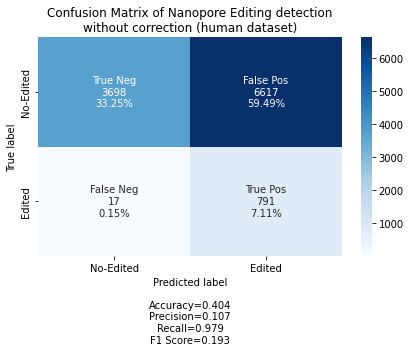

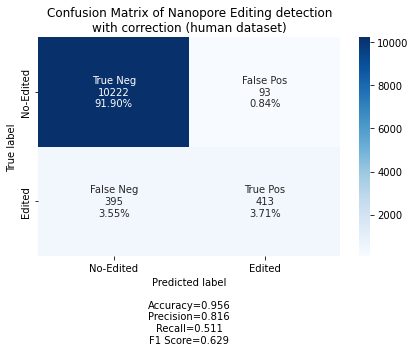

In [138]:
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["No-Edited", "Edited"]

# confusion matrices plots
utils.make_confusion_matrix(confusion_matrix(y_illumina, y_native), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of Nanopore Editing detection\nwithout correction (human dataset)",
                      figsize=(6,5), 
                      path="/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/ConfMatrix_wt_vs_OXPs_NoCorrection.tiff")

utils.make_confusion_matrix(confusion_matrix(y_illumina, y_corrected), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of Nanopore Editing detection\nwith correction (human dataset)",
                      figsize=(6,5),
                      path="/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/ConfMatrix_wt_vs_OXPs_iForestCorrection.tiff")

In [139]:
print("ONT Native (human dataset)")
print(classification_report(y_illumina, y_native))
print("Accuracy:", accuracy_score(y_illumina, y_native))
print("Recall:", recall_score(y_illumina, y_native))
print("Precision:", precision_score(y_illumina, y_native))
print("F1-score:", f1_score(y_illumina, y_native))
tn, fp, fn, tp = confusion_matrix(y_illumina, y_native).ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)
print()
print()
print("ONT Corrected (human dataset)")
print(classification_report(y_illumina, y_corrected))
print("Accuracy:", accuracy_score(y_illumina, y_corrected))
print("Recall:", recall_score(y_illumina, y_corrected))
print("Precision:", precision_score(y_illumina, y_corrected))
print("F1-score:", f1_score(y_illumina, y_corrected))
tn, fp, fn, tp = confusion_matrix(y_illumina, y_corrected).ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)
print()

ONT Native (human dataset)
              precision    recall  f1-score   support

           0       1.00      0.36      0.53     10315
           1       0.11      0.98      0.19       808

    accuracy                           0.40     11123
   macro avg       0.55      0.67      0.36     11123
weighted avg       0.93      0.40      0.50     11123

Accuracy: 0.40357817135664836
Recall: 0.9789603960396039
Precision: 0.10677645788336933
F1-score: 0.19255111976630965
Specificity: 0.3585070285991275


ONT Corrected (human dataset)
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10315
           1       0.82      0.51      0.63       808

    accuracy                           0.96     11123
   macro avg       0.89      0.75      0.80     11123
weighted avg       0.95      0.96      0.95     11123

Accuracy: 0.9561269441697384
Recall: 0.5111386138613861
Precision: 0.8162055335968379
F1-score: 0.6286149162861493
Specificity: 0.9909840

### Performing Illumina vs ONT frequency correlation

In [140]:
# performing correlation between illumina and ONT CT frequencies at ground truth sites (murine dataset)
wt_freqs = pd.merge(illumina_gt_mouse[["contig_mm39", "pos_mm39", "SubsFreq_WT"]], 
                    dfCT_wt_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                    right_on=["region", "position"],
                    left_on=["contig_mm39", "pos_mm39"]).drop(["region", "position"], axis=1)
ko_freqs = pd.merge(illumina_gt_mouse[["contig_mm39", "pos_mm39", "SubsFreq_KO"]], 
                    dfCT_ko_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                    right_on=["region", "position"],
                    left_on=["contig_mm39", "pos_mm39"]).drop(["region", "position"], axis=1)

In [141]:
wt_freqs

,contig_mm39,pos_mm39,SubsFreq_WT,strand_reditools,Tfreq_native,Tfreq_corrected
0,chr1,4915683,0.11,+,0.129630,0.000000
1,chr1,4915694,0.11,+,0.137255,0.058824
2,chr1,4915851,0.05,+,0.000000,0.000000
3,chr1,4916384,0.10,+,0.200000,0.030769
4,chr1,4967044,0.08,+,0.094340,0.047170
...,...,...,...,...,...,...
238,chrX,108204953,0.05,+,0.097222,0.027778
239,chrX,108205780,0.14,+,0.121212,0.030303
240,chrX,133507395,0.15,+,0.181818,0.054545
241,chrX,135147837,0.20,+,0.211538,0.057692


In [142]:
ko_freqs

,contig_mm39,pos_mm39,SubsFreq_KO,strand_reditools,Tfreq_native,Tfreq_corrected
0,chr1,4915683,0.0,+,0.037037,0.0
1,chr1,4915694,0.0,+,0.084337,0.0
2,chr1,4915851,0.0,+,0.000000,0.0
3,chr1,4916384,0.0,+,0.040404,0.0
4,chr1,4967044,0.0,+,0.032520,0.0
...,...,...,...,...,...,...
287,chrX,108204953,0.0,+,0.027027,0.0
288,chrX,108205780,0.0,+,0.007092,0.0
289,chrX,133507395,0.0,+,0.000000,0.0
290,chrX,139376667,0.0,+,0.000000,0.0


In [143]:
wt_freqs.SubsFreq_WT.to_list()+ko_freqs.SubsFreq_KO.to_list()

[0.11,
 0.11,
 0.05,
 0.1,
 0.08,
 0.09,
 0.05,
 0.05,
 0.1,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.15,
 0.12,
 0.06,
 0.05,
 0.07,
 0.05,
 0.06,
 0.06,
 0.06,
 0.06,
 0.05,
 0.05,
 0.08,
 0.14,
 0.05,
 0.22,
 0.06,
 0.07,
 0.42,
 0.05,
 0.06,
 0.05,
 0.08,
 0.22,
 0.09,
 0.11,
 0.05,
 0.13,
 0.09,
 0.13,
 0.08,
 0.06,
 0.09,
 0.06,
 0.05,
 0.05,
 0.07,
 0.09,
 0.06,
 0.06,
 0.05,
 0.06,
 0.14,
 0.17,
 0.16,
 0.05,
 0.08,
 0.18,
 0.06,
 0.06,
 0.05,
 0.1,
 0.08,
 0.06,
 0.09,
 0.05,
 0.06,
 0.09,
 0.05,
 0.12,
 0.22,
 0.05,
 0.06,
 0.11,
 0.2,
 0.05,
 0.06,
 0.05,
 0.07,
 0.06,
 0.06,
 0.05,
 0.06,
 0.08,
 0.46,
 0.08,
 0.05,
 0.06,
 0.05,
 0.1,
 0.06,
 0.06,
 0.06,
 0.39,
 0.06,
 0.08,
 0.07,
 0.05,
 0.05,
 0.08,
 0.08,
 0.15,
 0.06,
 0.05,
 0.08,
 0.24,
 0.09,
 0.06,
 0.09,
 0.16,
 0.06,
 0.05,
 0.05,
 0.07,
 0.05,
 0.07,
 0.1,
 0.05,
 0.11,
 0.06,
 0.05,
 0.05,
 0.06,
 0.05,
 0.05,
 0.05,
 0.13,
 0.05,
 0.05,
 0.13,
 0.1,
 0.09,
 0.05,
 0.1,
 0.05,
 0.49,
 0.21,
 0.05,


In [144]:
from scipy.stats import spearmanr

print("ONT Native - ILLUMINA CT FREQS vs ONT (ground truth sites) Murine dataset")
print(spearmanr(wt_freqs.SubsFreq_WT.to_list()+ko_freqs.SubsFreq_KO.to_list(), wt_freqs.Tfreq_native.to_list()+ko_freqs.Tfreq_native.to_list()))
print()
print("ONT Corrected - ILLUMINA CT FREQS vs ONT (ground truth sites) Murine dataset")
print(spearmanr(wt_freqs.SubsFreq_WT.to_list()+ko_freqs.SubsFreq_KO.to_list(), wt_freqs.Tfreq_corrected.to_list()+ko_freqs.Tfreq_corrected.to_list()))

ONT Native - ILLUMINA CT FREQS vs ONT (ground truth sites) Murine dataset
SpearmanrResult(correlation=0.7072923502559896, pvalue=2.527556247501827e-82)

ONT Corrected - ILLUMINA CT FREQS vs ONT (ground truth sites) Murine dataset
SpearmanrResult(correlation=0.7719112073431224, pvalue=6.233604680738128e-107)


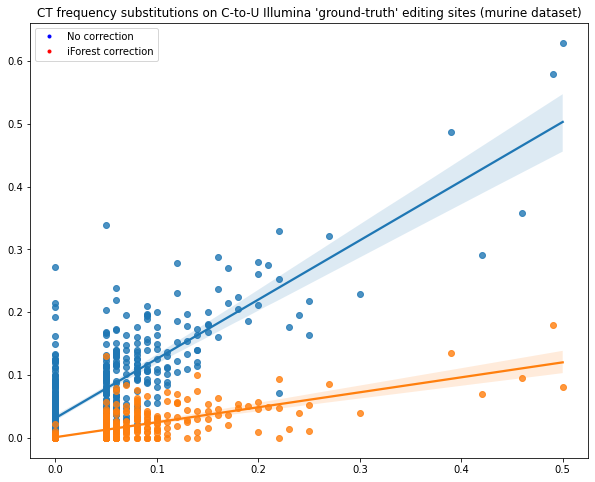

In [145]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10,8))
sn.regplot(x=wt_freqs.SubsFreq_WT.to_list()+ko_freqs.SubsFreq_KO.to_list(), 
           y=wt_freqs.Tfreq_native.to_list()+ko_freqs.Tfreq_native.to_list())
sn.regplot(x=wt_freqs.SubsFreq_WT.to_list()+ko_freqs.SubsFreq_KO.to_list(), 
           y=wt_freqs.Tfreq_corrected.to_list()+ko_freqs.Tfreq_corrected.to_list())
plt.legend(["Illumina vs ONT native", "Illumina vs ONT iForest correction"])
plt.title("CT frequency substitutions on C-to-U Illumina 'ground-truth' editing sites (murine dataset)")
custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='r', linestyle='None')]
plt.legend(custom, ['No correction', 'iForest correction'])
plt.show()

In [146]:
# performing correlation between illumina and ONT CT frequencies at ground truth sites
wt1_freqs = pd.merge(illumina_gt_human[["Region", "Position", "Frequency_mean_wt"]], 
                     dfCT_wt1_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                     right_on=["region", "position"],
                     left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
wt4_freqs = pd.merge(illumina_gt_human[["Region", "Position", "Frequency_mean_wt"]], 
                     dfCT_wt4_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                     right_on=["region", "position"],
                     left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
oxp1_freqs = pd.merge(illumina_gt_human[["Region", "Position", "Frequency_mean_oxp"]], 
                      dfCT_oxp1_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                      right_on=["region", "position"],
                      left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
oxp2_freqs = pd.merge(illumina_gt_human[["Region", "Position", "Frequency_mean_oxp"]], 
                      dfCT_oxp1_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                      right_on=["region", "position"],
                      left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
oxp3_freqs = pd.merge(illumina_gt_human[["Region", "Position", "Frequency_mean_oxp"]], 
                      dfCT_oxp3_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                      right_on=["region", "position"],
                      left_on=["Region", "Position"]).drop(["region", "position"], axis=1)
oxp4_freqs = pd.merge(illumina_gt_human[["Region", "Position", "Frequency_mean_oxp"]], 
                      dfCT_oxp4_aggregated_gt[["region", "position", "strand_reditools", "Tfreq_native", "Tfreq_corrected"]],
                      right_on=["region", "position"],
                      left_on=["Region", "Position"]).drop(["region", "position"], axis=1)

In [147]:
wt1_freqs

,Region,Position,Frequency_mean_wt,strand_reditools,Tfreq_native,Tfreq_corrected
0,chrX,11121859,0.0,+,0.068182,0.0
1,chrX,12822907,0.0,+,0.015873,0.0
2,chrX,12822954,0.0,+,0.016393,0.0
3,chrX,12823016,0.0,+,0.054688,0.0
4,chrX,12823260,0.0,+,0.108108,0.0
...,...,...,...,...,...,...
6490,chr8,129855631,0.0,-,0.022727,0.0
6491,chr8,129871380,0.0,-,0.020202,0.0
6492,chr8,140515894,0.0,+,0.112903,0.0
6493,chr8,140516538,0.0,+,0.012658,0.0


In [148]:
wt4_freqs

,Region,Position,Frequency_mean_wt,strand_reditools,Tfreq_native,Tfreq_corrected
0,chrX,11121859,0.0,+,0.072727,0.0
1,chrX,12822907,0.0,+,0.000000,0.0
2,chrX,12822954,0.0,+,0.015873,0.0
3,chrX,12823016,0.0,+,0.071429,0.0
4,chrX,12823260,0.0,+,0.078125,0.0
...,...,...,...,...,...,...
3815,chr8,129850889,0.0,-,0.033333,0.0
3816,chr8,129852181,0.0,-,0.036364,0.0
3817,chr8,129854325,0.0,-,0.000000,0.0
3818,chr8,129871380,0.0,-,0.076923,0.0


In [149]:
oxp1_freqs

,Region,Position,Frequency_mean_oxp,strand_reditools,Tfreq_native,Tfreq_corrected
0,chrX,16844690,0.283333,-,0.203125,0.031250
1,chrX,16844804,0.343333,-,0.285714,0.035714
2,chrX,48528648,0.050000,+,0.057692,0.000000
3,chrX,51902212,0.073333,+,0.085106,0.000000
4,chrX,54815986,0.180000,+,0.144444,0.011111
...,...,...,...,...,...,...
425,chr8,96231000,0.146667,-,0.137339,0.021459
426,chr8,97852473,0.140000,+,0.209877,0.012346
427,chr8,100703304,0.070000,-,0.084034,0.012605
428,chr8,100712675,0.056667,-,0.128440,0.009174


In [150]:
oxp2_freqs

,Region,Position,Frequency_mean_oxp,strand_reditools,Tfreq_native,Tfreq_corrected
0,chrX,16844690,0.283333,-,0.203125,0.031250
1,chrX,16844804,0.343333,-,0.285714,0.035714
2,chrX,48528648,0.050000,+,0.057692,0.000000
3,chrX,51902212,0.073333,+,0.085106,0.000000
4,chrX,54815986,0.180000,+,0.144444,0.011111
...,...,...,...,...,...,...
425,chr8,96231000,0.146667,-,0.137339,0.021459
426,chr8,97852473,0.140000,+,0.209877,0.012346
427,chr8,100703304,0.070000,-,0.084034,0.012605
428,chr8,100712675,0.056667,-,0.128440,0.009174


In [151]:
oxp3_freqs

,Region,Position,Frequency_mean_oxp,strand_reditools,Tfreq_native,Tfreq_corrected
0,chrX,77905299,0.073333,+,0.142857,0.017857
1,chr12,53479566,0.183333,+,0.087719,0.000000
2,chr11,62888774,0.056667,+,0.119403,0.029851
3,chr11,64316748,0.053333,-,0.037736,0.000000
4,chr10,17237418,0.076667,+,0.035294,0.011765
5,chr10,17237427,0.293333,+,0.283784,0.000000
6,chr10,17237517,0.080000,+,0.048193,0.000000
7,chr10,97433395,0.123333,+,0.064103,0.012821
8,chr17,1344562,0.210000,-,0.197802,0.032967
9,chr17,5432840,0.183333,-,0.100000,0.014286


In [152]:
oxp4_freqs

,Region,Position,Frequency_mean_oxp,strand_reditools,Tfreq_native,Tfreq_corrected
0,chrX,77905299,0.073333,+,0.082474,0.010309
1,chrX,115650604,0.060000,+,0.000000,0.000000
2,chr13,30461081,0.103333,-,0.016129,0.016129
3,chr13,30461206,0.096667,-,0.034483,0.000000
4,chr12,53479566,0.183333,+,0.151515,0.030303
...,...,...,...,...,...,...
60,chr1,203870040,0.156667,+,0.105263,0.035088
61,chr1,228099165,0.123333,+,0.050000,0.010000
62,chr8,85481408,0.050000,+,0.056604,0.018868
63,chr8,96230961,0.060000,-,0.140000,0.030000


In [153]:
print("ONT Native - ILLUMINA CT FREQS vs ONT (ground truth sites) Human dataset")
print(spearmanr(wt1_freqs.Frequency_mean_wt.to_list()+wt4_freqs.Frequency_mean_wt.to_list()+oxp1_freqs.Frequency_mean_oxp.to_list()+oxp2_freqs.Frequency_mean_oxp.to_list()+oxp3_freqs.Frequency_mean_oxp.to_list()+oxp4_freqs.Frequency_mean_oxp.to_list(), 
                wt1_freqs.Tfreq_native.to_list()+wt4_freqs.Tfreq_native.to_list()+oxp1_freqs.Tfreq_native.to_list()+oxp2_freqs.Tfreq_native.to_list()+oxp3_freqs.Tfreq_native.to_list()+oxp4_freqs.Tfreq_native.to_list()))
print()
print("ONT Corrected - ILLUMINA CT FREQS vs ONT (ground truth sites) Human dataset")
print(spearmanr(wt1_freqs.Frequency_mean_wt.to_list()+wt4_freqs.Frequency_mean_wt.to_list()+oxp1_freqs.Frequency_mean_oxp.to_list()+oxp2_freqs.Frequency_mean_oxp.to_list()+oxp3_freqs.Frequency_mean_oxp.to_list()+oxp4_freqs.Frequency_mean_oxp.to_list(), 
                wt1_freqs.Tfreq_corrected.to_list()+wt4_freqs.Tfreq_corrected.to_list()+oxp1_freqs.Tfreq_corrected.to_list()+oxp2_freqs.Tfreq_corrected.to_list()+oxp3_freqs.Tfreq_corrected.to_list()+oxp4_freqs.Tfreq_corrected.to_list()))

ONT Native - ILLUMINA CT FREQS vs ONT (ground truth sites) Human dataset
SpearmanrResult(correlation=0.39705872599614633, pvalue=0.0)

ONT Corrected - ILLUMINA CT FREQS vs ONT (ground truth sites) Human dataset
SpearmanrResult(correlation=0.630820753184195, pvalue=0.0)


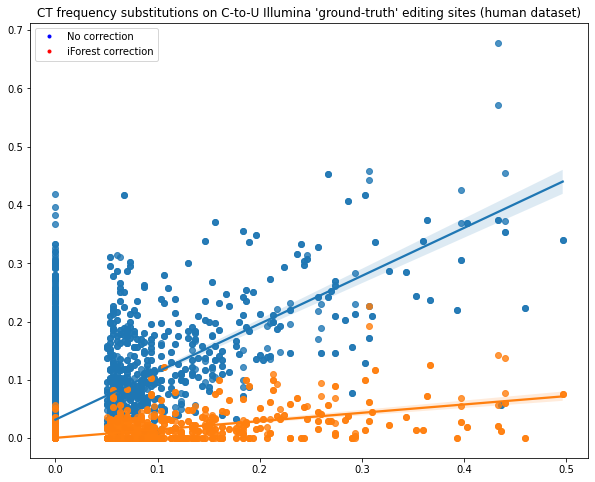

In [154]:
plt.figure(figsize=(10,8))
sn.regplot(x=wt1_freqs.Frequency_mean_wt.to_list()+wt4_freqs.Frequency_mean_wt.to_list()+oxp1_freqs.Frequency_mean_oxp.to_list()+oxp2_freqs.Frequency_mean_oxp.to_list()+oxp3_freqs.Frequency_mean_oxp.to_list()+oxp4_freqs.Frequency_mean_oxp.to_list(), 
           y=wt1_freqs.Tfreq_native.to_list()+wt4_freqs.Tfreq_native.to_list()+oxp1_freqs.Tfreq_native.to_list()+oxp2_freqs.Tfreq_native.to_list()+oxp3_freqs.Tfreq_native.to_list()+oxp4_freqs.Tfreq_native.to_list())
sn.regplot(x=wt1_freqs.Frequency_mean_wt.to_list()+wt4_freqs.Frequency_mean_wt.to_list()+oxp1_freqs.Frequency_mean_oxp.to_list()+oxp2_freqs.Frequency_mean_oxp.to_list()+oxp3_freqs.Frequency_mean_oxp.to_list()+oxp4_freqs.Frequency_mean_oxp.to_list(), 
           y=wt1_freqs.Tfreq_corrected.to_list()+wt4_freqs.Tfreq_corrected.to_list()+oxp1_freqs.Tfreq_corrected.to_list()+oxp2_freqs.Tfreq_corrected.to_list()+oxp3_freqs.Tfreq_corrected.to_list()+oxp4_freqs.Tfreq_corrected.to_list())
plt.legend(["Illumina vs ONT native", "Illumina vs ONT iForest correction"])
plt.title("CT frequency substitutions on C-to-U Illumina 'ground-truth' editing sites (human dataset)")
custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='r', linestyle='None')]
plt.legend(custom, ['No correction', 'iForest correction'])
plt.show()

## Prediction on indipendent synthetic dataset

In [155]:
cc2_filepaths = glob.glob("/lustre/bio_running/C_to_U_editing_minimap2_spliced/cc2.basecalling_features/cc2.CTcontext_reads_features_forward_rev/CTcontext_reads_features_forward_rev_chr*")
dfCT_cc2 = pd.concat([pd.read_table(d, header=None, names=col_names) for d in cc2_filepaths], axis = 0)
dfCT_cc2

,region,position,read_name,strand,pos-3,pos-2,pos-1,pos0,pos1,pos2,pos3,ins
0,chr1,37,74812362-a9e6-46ad-912a-b0841cd79a8c,+,4.0,-2.0,2.0,4.0,7.0,4.0,10.0,0.0
1,chr1,37,f33cebf9-cd1f-48bb-9931-f1c0f88f2921,+,6.0,-3.0,3.0,10.0,20.0,15.0,24.0,0.0
2,chr1,37,0a720a33-e441-4d63-bb97-daccc349f071,+,8.0,-3.0,2.0,6.0,9.0,9.0,26.0,0.0
3,chr1,37,8d3440fd-247f-4ad1-890c-fe47629ffaac,+,12.0,11.0,9.0,9.0,18.0,13.0,22.0,0.0
4,chr1,47,94ff569f-8e50-44d7-a7a0-1c5904b029ff,+,29.0,22.0,19.0,16.0,26.0,27.0,23.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1340144,chr2,2484,155c07a2-8625-4f8b-b61a-31200e0f3f8f,+,17.0,18.0,17.0,8.0,4.0,9.0,10.0,0.0
1340145,chr2,2484,fff3f719-f84e-4908-b35c-653bf1e2d2c6,+,15.0,-4.0,20.0,9.0,10.0,5.0,4.0,0.0
1340146,chr2,2484,fd9fd06f-a934-4823-a8f2-a76db45ba142,+,19.0,17.0,18.0,5.0,9.0,21.0,19.0,0.0
1340147,chr2,2484,ef586d94-3f7f-4649-aaf9-8f4778e4522b,+,32.0,18.0,18.0,10.0,19.0,17.0,14.0,0.0


In [156]:
# encode basecalling features
dfCT_cc2_enc = reduce_basecalling_features(dfCT_cc2)
dfCT_cc2_enc

100%|██████████| 4665168/4665168 [01:58<00:00, 39347.49it/s]


,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
0,chr1,37,74812362-a9e6-46ad-912a-b0841cd79a8c,+,4.0,4.7,1,0,0
1,chr1,37,f33cebf9-cd1f-48bb-9931-f1c0f88f2921,+,10.0,11.6,1,0,0
2,chr1,37,0a720a33-e441-4d63-bb97-daccc349f071,+,6.0,9.0,1,0,0
3,chr1,37,8d3440fd-247f-4ad1-890c-fe47629ffaac,+,9.0,13.4,0,0,0
4,chr1,47,94ff569f-8e50-44d7-a7a0-1c5904b029ff,+,16.0,23.1,0,0,1
...,...,...,...,...,...,...,...,...,...
4665163,chr2,2484,155c07a2-8625-4f8b-b61a-31200e0f3f8f,+,8.0,11.9,0,0,0
4665164,chr2,2484,fff3f719-f84e-4908-b35c-653bf1e2d2c6,+,9.0,9.6,1,0,0
4665165,chr2,2484,fd9fd06f-a934-4823-a8f2-a76db45ba142,+,5.0,15.4,0,0,0
4665166,chr2,2484,ef586d94-3f7f-4649-aaf9-8f4778e4522b,+,10.0,18.3,0,0,0


In [157]:
# delete not encoded basecalling features to spare memory
del(dfCT_cc2)

In [158]:
# aggragate native data on genome space
dfCT_cc2_enc_genomespace = dfCT_cc2_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_native").reset_index()
dfCT_cc2_enc_genomespace

,region,position,strand,T_native
0,chr1,37,+,4
1,chr1,47,+,181
2,chr1,55,+,86
3,chr1,61,+,110
4,chr1,62,+,156
...,...,...,...,...
2795,chr4,2723,+,3255
2796,chr4,2724,-,1
2797,chr4,2727,+,698
2798,chr4,2730,-,2


In [159]:
dfCT_cc2_enc_genomespace.describe()

,position,T_native
count,2800.000000,2800.000000
mean,1301.325357,1666.131429
std,739.224617,3023.578433
min,34.000000,1.000000
25%,657.750000,140.000000
50%,1308.000000,584.500000
75%,1932.500000,1900.250000
max,2733.000000,56369.000000


In [160]:
# retain only reads without indels and mismatches
dfCT_cc2_enc = dfCT_cc2_enc.query("n_ins <= 0").query("n_dels <= 0").query("n_mismatches <=0")
dfCT_cc2_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins
3,chr1,37,8d3440fd-247f-4ad1-890c-fe47629ffaac,+,9.0,13.4,0,0,0
22,chr1,47,e3712aa3-84c2-4db4-9ced-b639b9f5e1ff,+,8.0,13.6,0,0,0
24,chr1,47,b1468927-ed2c-4820-8306-35dc6e1d3789,+,5.0,6.7,0,0,0
25,chr1,47,80ea16f0-1009-4b16-b7c8-36450a4008d6,+,5.0,10.9,0,0,0
28,chr1,47,3def7529-6e3b-492c-b8c4-a51456b4384f,+,11.0,21.3,0,0,0
...,...,...,...,...,...,...,...,...,...
4665162,chr2,2484,133ab661-cb21-44e0-98dc-ed267f0b6d96,+,7.0,17.3,0,0,0
4665163,chr2,2484,155c07a2-8625-4f8b-b61a-31200e0f3f8f,+,8.0,11.9,0,0,0
4665165,chr2,2484,fd9fd06f-a934-4823-a8f2-a76db45ba142,+,5.0,15.4,0,0,0
4665166,chr2,2484,ef586d94-3f7f-4649-aaf9-8f4778e4522b,+,10.0,18.3,0,0,0


In [161]:
# assess how many sites remain after mismatches and indels filtering
dfCT_cc2_enc.groupby(["region", "position", "strand"]).size().to_frame(name="T_filtered").reset_index()

,region,position,strand,T_filtered
0,chr1,37,+,1
1,chr1,47,+,27
2,chr1,55,+,2
3,chr1,61,+,3
4,chr1,62,+,19
...,...,...,...,...
2525,chr4,2719,+,27
2526,chr4,2722,+,33
2527,chr4,2723,+,22
2528,chr4,2727,+,11


In [162]:
# predict with iforest after scaling to z-scores
dfCT_cc2_enc["y_hat"] = clf.predict(sc.transform(dfCT_cc2_enc.iloc[:,4:6]))
dfCT_cc2_enc

,region,position,read_name,strand,Tqual,MeanQual,n_mismatches,n_dels,n_ins,y_hat
3,chr1,37,8d3440fd-247f-4ad1-890c-fe47629ffaac,+,9.0,13.4,0,0,0,1
22,chr1,47,e3712aa3-84c2-4db4-9ced-b639b9f5e1ff,+,8.0,13.6,0,0,0,1
24,chr1,47,b1468927-ed2c-4820-8306-35dc6e1d3789,+,5.0,6.7,0,0,0,1
25,chr1,47,80ea16f0-1009-4b16-b7c8-36450a4008d6,+,5.0,10.9,0,0,0,1
28,chr1,47,3def7529-6e3b-492c-b8c4-a51456b4384f,+,11.0,21.3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4665162,chr2,2484,133ab661-cb21-44e0-98dc-ed267f0b6d96,+,7.0,17.3,0,0,0,1
4665163,chr2,2484,155c07a2-8625-4f8b-b61a-31200e0f3f8f,+,8.0,11.9,0,0,0,1
4665165,chr2,2484,fd9fd06f-a934-4823-a8f2-a76db45ba142,+,5.0,15.4,0,0,0,1
4665166,chr2,2484,ef586d94-3f7f-4649-aaf9-8f4778e4522b,+,10.0,18.3,0,0,0,1


In [163]:
dfCT_cc2_enc["y_hat"].value_counts()

 1    1125435
-1      36518
Name: y_hat, dtype: int64

In [164]:
dfCT_cc2_enc.groupby("y_hat").describe().T

y_hat                         -1             1
position     count  36518.000000  1.125435e+06
             mean    1455.292157  1.506665e+03
             std      738.694879  7.317908e+02
             min       38.000000  3.700000e+01
             25%      875.000000  9.250000e+02
             50%     1524.000000  1.566000e+03
             75%     2087.000000  2.131000e+03
             max     2733.000000  2.733000e+03
Tqual        count  36518.000000  1.125435e+06
             mean      11.132948  6.819246e+00
             std        8.324382  3.762641e+00
             min        1.000000  2.000000e+00
             25%        4.000000  4.000000e+00
             50%        9.000000  6.000000e+00
             75%       17.000000  8.000000e+00
             max       45.000000  3.100000e+01
MeanQual     count  36518.000000  1.125435e+06
             mean      17.720579  1.413842e+01
             std        8.629424  4.237131e+00
             min        2.300000  4.100000e+00
             25%        8.400000  1.100000e+01
             50%       22.300000  1.400000e+01
             75%       25.100000  1.730000e+01
             max       36.300000  2.660000e+01
n_mismatches count  36518.000000  1.125435e+06
             mean       0.000000  0.000000e+00
             std        0.000000  0.000000e+00
             min        0.000000  0.000000e+00
             25%        0.000000  0.000000e+00
             50%        0.000000  0.000000e+00
             75%        0.000000  0.000000e+00
             max        0.000000  0.000000e+00
n_dels       count  36518.000000  1.125435e+06
             mean       0.000000  0.000000e+00
             std        0.000000  0.000000e+00
             min        0.000000  0.000000e+00
             25%        0.000000  0.000000e+00
             50%        0.000000  0.000000e+00
             75%        0.000000  0.000000e+00
             max        0.000000  0.000000e+00
n_ins        count  36518.000000  1.125435e+06
             mean       0.000000  0.000000e+00
             std        0.000000  0.000000e+00
             min        0.000000  0.000000e+00
             25%        0.000000  0.000000e+00
             50%        0.000000  0.000000e+00
             75%        0.000000  0.000000e+00
             max        0.000000  0.000000e+00

In [165]:
# aggragate corrected data on genome space
dfCT_cc2_enc_corrected_genomespace = dfCT_cc2_enc.query("y_hat == -1").groupby(["region", "position", "strand"]).size().to_frame(name="T_corrected").reset_index()
dfCT_cc2_enc_corrected_genomespace

,region,position,strand,T_corrected
0,chr1,47,+,3
1,chr1,55,+,1
2,chr1,61,+,1
3,chr1,62,+,2
4,chr1,70,+,5
...,...,...,...,...
1930,chr4,2719,+,2
1931,chr4,2722,+,2
1932,chr4,2723,+,7
1933,chr4,2727,+,1


In [166]:
dfCT_cc2_enc_corrected_genomespace.describe()

,position,T_corrected
count,1935.000000,1935.000000
mean,1342.218605,18.872351
std,740.577571,62.183658
min,38.000000,1.000000
25%,693.000000,2.000000
50%,1363.000000,5.000000
75%,1969.000000,13.000000
max,2733.000000,972.000000


In [167]:
# aggregate T native and corrected data on genome space
dfCT_aggregated = pd.merge(dfCT_cc2_enc_genomespace, 
                           dfCT_cc2_enc_corrected_genomespace,
                           how="left")
dfCT_aggregated.fillna(0, inplace=True)
dfCT_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,37,+,4,0.0
1,chr1,47,+,181,3.0
2,chr1,55,+,86,1.0
3,chr1,61,+,110,1.0
4,chr1,62,+,156,2.0
...,...,...,...,...,...
2795,chr4,2723,+,3255,7.0
2796,chr4,2724,-,1,0.0
2797,chr4,2727,+,698,1.0
2798,chr4,2730,-,2,0.0


In [168]:
# drop (minus strand cause were in vitro transcribed sequences)
dfCT_aggregated.query("strand == '+'").reset_index(inplace=True, drop=True)
dfCT_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,37,+,4,0.0
1,chr1,47,+,181,3.0
2,chr1,55,+,86,1.0
3,chr1,61,+,110,1.0
4,chr1,62,+,156,2.0
...,...,...,...,...,...
2795,chr4,2723,+,3255,7.0
2796,chr4,2724,-,1,0.0
2797,chr4,2727,+,698,1.0
2798,chr4,2730,-,2,0.0


In [169]:
# retrieve curlcake candidate C editing sites positions
import pysam

ref_filepath = "/lustre/bio_running/curlcakes_runs/refs/cc.fasta"

Cpos = []

ref = pysam.FastaFile(ref_filepath)
for contig in ref.references:
    seq = ref.fetch(contig)
    for c,base in enumerate(seq):
        if base == "C":
            Cpos.append([contig, c+1, "+"])
ref.close()

Cpos = pd.DataFrame(Cpos, columns=["region", "position", "strand"])
Cpos

,region,position,strand
0,chr1,3,+
1,chr1,14,+
2,chr1,17,+
3,chr1,19,+
4,chr1,21,+
...,...,...,...
2516,chr4,2719,+
2517,chr4,2722,+
2518,chr4,2723,+
2519,chr4,2727,+


In [170]:
# merge with aggregated data
dfCT_aggregated = pd.merge(Cpos, dfCT_aggregated, how="left").fillna(0)
dfCT_aggregated

,region,position,strand,T_native,T_corrected
0,chr1,3,+,0.0,0.0
1,chr1,14,+,0.0,0.0
2,chr1,17,+,0.0,0.0
3,chr1,19,+,0.0,0.0
4,chr1,21,+,0.0,0.0
...,...,...,...,...,...
2516,chr4,2719,+,488.0,2.0
2517,chr4,2722,+,56369.0,2.0
2518,chr4,2723,+,3255.0,7.0
2519,chr4,2727,+,698.0,1.0


In [171]:
# retrieve stranded depth for each position
# start computation
bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/cc2.bam"
bam = pysam.AlignmentFile(bam_filepath) # opening bamfile via pysam
depths_stranded = []
with tqdm(total=dfCT_aggregated.shape[0]) as pbar:
    for s in dfCT_aggregated.itertuples():
        try:
            d = retrieve_depth_stranded(bam, s.region, s.position, s.strand)
        except UnboundLocalError:
            d = 0
        depths_stranded.append(d)
        pbar.update(1)
bam.close()

# append depths_stranded columns to final dataframe of aggregated data
dfCT_aggregated["depth_stranded"] = depths_stranded
dfCT_aggregated

100%|██████████| 2521/2521 [7:55:46<00:00, 11.32s/it]   


,region,position,strand,T_native,T_corrected,depth_stranded
0,chr1,3,+,0.0,0.0,0
1,chr1,14,+,0.0,0.0,0
2,chr1,17,+,0.0,0.0,0
3,chr1,19,+,0.0,0.0,0
4,chr1,21,+,0.0,0.0,0
...,...,...,...,...,...,...
2516,chr4,2719,+,488.0,2.0,138447
2517,chr4,2722,+,56369.0,2.0,137772
2518,chr4,2723,+,3255.0,7.0,138874
2519,chr4,2727,+,698.0,1.0,139638


In [172]:
# produce frequencies
dfCT_aggregated["Tfreq_native"] = dfCT_aggregated["T_native"] / dfCT_aggregated["depth_stranded"]
dfCT_aggregated["Tfreq_corrected"] = dfCT_aggregated["T_corrected"] / dfCT_aggregated["depth_stranded"]
dfCT_aggregated

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,3,+,0.0,0.0,0,NaN,NaN
1,chr1,14,+,0.0,0.0,0,NaN,NaN
2,chr1,17,+,0.0,0.0,0,NaN,NaN
3,chr1,19,+,0.0,0.0,0,NaN,NaN
4,chr1,21,+,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
2516,chr4,2719,+,488.0,2.0,138447,0.003525,0.000014
2517,chr4,2722,+,56369.0,2.0,137772,0.409147,0.000015
2518,chr4,2723,+,3255.0,7.0,138874,0.023439,0.000050
2519,chr4,2727,+,698.0,1.0,139638,0.004999,0.000007


In [173]:
# save to disk prediction and aggregated data
dfCT_cc2_enc.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_cc2.tsv",
                    sep="\t",
                    index=None)
dfCT_aggregated.to_csv("/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/dfCT_predicted_aggregated_cc2.tsv", 
                       sep="\t",
                       index=None)

In [174]:
# drop sites with stranded depth lower than 50
dfCT_aggregated = dfCT_aggregated.query("depth_stranded > 50").reset_index(drop=True)
dfCT_aggregated

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,33,+,0.0,0.0,96,0.000000,0.000000
1,chr1,34,+,0.0,0.0,184,0.000000,0.000000
2,chr1,37,+,4.0,0.0,1377,0.002905,0.000000
3,chr1,47,+,181.0,3.0,11601,0.015602,0.000259
4,chr1,55,+,86.0,1.0,11742,0.007324,0.000085
...,...,...,...,...,...,...,...,...
2494,chr4,2719,+,488.0,2.0,138447,0.003525,0.000014
2495,chr4,2722,+,56369.0,2.0,137772,0.409147,0.000015
2496,chr4,2723,+,3255.0,7.0,138874,0.023439,0.000050
2497,chr4,2727,+,698.0,1.0,139638,0.004999,0.000007


In [175]:
# print statistics
dfCT_aggregated.describe()

,position,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
count,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000
mean,1277.230892,1866.653461,14.611445,80536.102841,0.023712,0.000194
std,739.391706,3141.563305,55.281722,37222.795644,0.034716,0.000715
min,32.000000,0.000000,0.000000,80.000000,0.000000,0.000000
25%,633.000000,248.000000,1.000000,58588.000000,0.003857,0.000008
50%,1271.000000,763.000000,3.000000,81934.000000,0.011404,0.000037
75%,1908.500000,2196.000000,9.000000,106227.000000,0.028588,0.000123
max,2733.000000,56369.000000,972.000000,147582.000000,0.409147,0.013869


In [176]:
# compute some metrics
threshold = 0.01

y_true = []
y_native = []
y_corrected = []

# for cc2 sites
for s in dfCT_aggregated.itertuples():
    y_true.append(0)
    # predict native label
    if s.Tfreq_native > threshold:
        y_native.append(1)
    else:
        y_native.append(0)
    # predict corrected label
    if s.Tfreq_corrected > threshold:
        y_corrected.append(1)
    else:
        y_corrected.append(0)


print(len(y_true))
print(len(y_native))
print(len(y_corrected))

2499
2499
2499


/lustrehome/afonzino/C_to_U_classifier_plus_min/utils.py:260: RuntimeWarning: invalid value encountered in long_scalars
  recall    = cf[1,1] / sum(cf[1,:])
/lustrehome/afonzino/C_to_U_classifier_plus_min/utils.py:260: RuntimeWarning: invalid value encountered in long_scalars
  recall    = cf[1,1] / sum(cf[1,:])


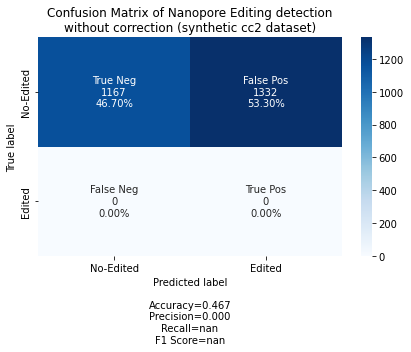

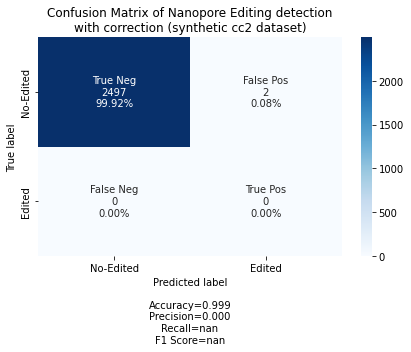

In [177]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["No-Edited", "Edited"]

# confusion matrices plots
utils.make_confusion_matrix(confusion_matrix(y_true, y_native), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of Nanopore Editing detection\nwithout correction (synthetic cc2 dataset)",
                      figsize=(6,5), 
                      path="/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/ConfMatrix_cc2_NoCorrection.tiff")

utils.make_confusion_matrix(confusion_matrix(y_true, y_corrected), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of Nanopore Editing detection\nwith correction (synthetic cc2 dataset)",
                      figsize=(6,5),
                      path="/lustre/bio_running/CtoUclassifier_new_model_training23052022/src_jupyter_notebooks/iForest_cc1_wt_ko_no_indels_mismatches___NEW_TRAINING/ConfMatrix_cc2_iForestCorrection.tiff")

In [178]:
print("ONT Native (synthetic dataset)")
print(classification_report(y_true, y_native))
print("Accuracy:", accuracy_score(y_true, y_native))
print()
print()
print("ONT Corrected (synthetic dataset)")
print(classification_report(y_true, y_corrected))
print("Accuracy:", accuracy_score(y_true, y_corrected))
print()

ONT Native (synthetic dataset)
              precision    recall  f1-score   support

           0       1.00      0.47      0.64      2499
           1       0.00      0.00      0.00         0

    accuracy                           0.47      2499
   macro avg       0.50      0.23      0.32      2499
weighted avg       1.00      0.47      0.64      2499

Accuracy: 0.4669867947178872


ONT Corrected (synthetic dataset)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2499
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2499
   macro avg       0.50      0.50      0.50      2499
weighted avg       1.00      1.00      1.00      2499

Accuracy: 0.9991996798719488



/lustre/bio_running/C_to_U_editing/src/C_to_U_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/bio_running/C_to_U_editing/src/C_to_U_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/bio_running/C_to_U_editing/src/C_to_U_classifier/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 